* 요일: &we=[0, 2, 3, 4, 5, 6] <br>
* 전체, 홈, 원정: &ha, &ha=H or &ha=N <br>
* 구단(14-24): &ct=[1, 2, 3, 6, 7, 9, 11, 12, 13] <br>
기아: 2
삼성: 1
두산: 6
SSG: 9
롯데: 3
한화: 7
엔씨: 12
KT: 13
키움: 11

**컬럼명 해설**<br>
```python
df_kia_thu.columns

Index(['Year', 'G', 'GS', 'W', 'L', 'S', 'HD', 'IP', 'R', 'ER', 'RS', 'RS9',
       'TBF', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'IB', 'HP', 'SO', 'SF', 'NP',
       'WHIP', 'AVG', 'OBP', 'OPS', 'ERA'],
      dtype='object')
```

연도, 게임 수, 선발, 이긴 경기 수, 진 경기 수, 세이브, 홀드, 이닝 수, 득점, 자책점, 득점 지원, 9이닝당 득점지원, 상대한 타자 수, 상대팀 타수, 안타, 2루타, 3루타, 홈런, 4구, 고의 4구, 사구, 삼진, 희생플라이, 투구 수, 이닝당 출루 허용률, 피안타율, 피출루율, 피OPS, 평균자책점

**모델 생성할 때 참고한 코드(chatgpt)**

```python
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 데이터 설정 (연도, 단어 공부 시간, 문법 공부 시간, 영어 점수)
years = np.array([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]).reshape(-1, 1)
vocab_hours = np.array([10, 15, 14, 17, 8, 15, 9, 11, 13, 16])
grammar_hours = np.array([7, 6, 8, 5, 3, 10, 6, 8, 9, 10])
english_scores = np.array([87, 90, 81, 95, 79, 99, 84, 88, 92, 97])

# 단어 공부 시간과 문법 공부 시간을 함께 예측하는 모델
X_years = years  # 연도를 독립 변수로 사용
Y_hours = np.column_stack((vocab_hours, grammar_hours))

model_hours = LinearRegression()
model_hours.fit(X_years, Y_hours)

# 2025년 단어 공부 시간과 문법 공부 시간 예측
pred_hours = model_hours.predict([[2025]])[0]
pred_vocab_hours, pred_grammar_hours = pred_hours

# 영어 점수 예측 모델
X = np.column_stack((vocab_hours, grammar_hours))
y = english_scores
model_score = LinearRegression()
model_score.fit(X, y)

# 2025년 예측 데이터
pred_X = np.array([[pred_vocab_hours, pred_grammar_hours]])

# 영어 점수 예측
predicted_score = model_score.predict(pred_X)[0]
print(f"2025년 예상 단어 공부 시간: {pred_vocab_hours:.2f}")
print(f"2025년 예상 문법 공부 시간: {pred_grammar_hours:.2f}")
print(f"2025년 예상 영어 점수: {predicted_score:.2f}")
```

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import requests
from re import escape
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

plt.rcParams['font.family'] = 'Malgun Gothic'

In [2]:
import matplotlib.font_manager as fm

# 시스템에 설치된 모든 폰트 목록 가져오기
font_list = sorted([f.name for f in fm.fontManager.ttflist])

print(font_list)

['Agency FB', 'Agency FB', 'Algerian', 'Ami R', 'Arial', 'Arial', 'Arial', 'Arial', 'Arial', 'Arial', 'Arial', 'Arial', 'Arial', 'Arial Rounded MT Bold', 'Arvo', 'Bahnschrift', 'Baskerville Old Face', 'Batang', 'Bauhaus 93', 'Bell MT', 'Bell MT', 'Bell MT', 'Berlin Sans FB', 'Berlin Sans FB', 'Berlin Sans FB Demi', 'Bernard MT Condensed', 'Blackadder ITC', 'Bodoni MT', 'Bodoni MT', 'Bodoni MT', 'Bodoni MT', 'Bodoni MT', 'Bodoni MT', 'Bodoni MT', 'Bodoni MT', 'Bodoni MT', 'Bodoni MT', 'Bodoni MT', 'Book Antiqua', 'Book Antiqua', 'Book Antiqua', 'Book Antiqua', 'Bookman Old Style', 'Bookman Old Style', 'Bookman Old Style', 'Bookman Old Style', 'Bookshelf Symbol 7', 'Bradley Hand ITC', 'Britannic Bold', 'Broadway', 'Brush Script MT', 'Cafe24 Ssurround', 'Calibri', 'Calibri', 'Calibri', 'Calibri', 'Calibri', 'Calibri', 'Californian FB', 'Californian FB', 'Californian FB', 'Calisto MT', 'Calisto MT', 'Calisto MT', 'Calisto MT', 'Cambria', 'Cambria', 'Cambria', 'Cambria', 'Candara', 'Candara

In [3]:
plt.rcParams['font.family'] = 'Noto Sans KR'

---

# 1. 전체

In [41]:
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

team_list = [1, 2, 3, 6, 7, 9, 11, 12, 13]  #삼성, 기아, 롯데, 두산, 한화, SSG, 키움, 엔씨, KT
df_team_list = []    #전체 구단 데이터프레임 담을 리스트

for team in team_list:
    url = 'https://statiz.sporki.com/stats/?m=team&m2=pitching&m3=situation1&so=s_year&ob=&year=2024&sy=2015&ey=2024&te=5002&po=&lt=10100&reg=&pe=&ds=&de=&we=&hr=&ha&ct={}&st=&vp=&bo=&pt=&pp=&ii=&vc=&um=&oo=&rr=&sc=&bc=&ba=&li=&as=&ae=&pl=&gc=&lr=&pr=50&ph=&hs=&us=&na=&ls=&sf1=&sk1=&sv1=&sf2=&sk2=&sv2='.format(team)
    driver.get(url)

    try:
        div = WebDriverWait(driver, 20).until(
            EC.presence_of_element_located((By.CLASS_NAME, "table_type01"))
        )
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        div_content = soup.find('div', class_='table_type01 transverse_scroll cbox')

        print(team)
        print(url)

        if div_content:
            first_table = div_content.find('table') #첫 번째 table 태그만 가져옴

        #헤더 추출
        headers = [th.text.strip() for th in first_table.find_all('th')]

        #데이터프레임 컬럼을 만들기 위해 불필요한 헤더 삭제
        rm = ['Rank', 'Season', 'Year▲', '비율', 'Year']    #삭제할 헤더명
        idx = [i for i, x in enumerate(headers) if x in rm] #삭제할 헤더 index

        columns = [x for i, x in enumerate(headers) if i not in idx]    #삭제 후 남은 헤더
        columns[0] = 'Year' #컬럼명 변경: 정렬▲ → Year

        columns = np.array(columns)

        #각 컬럼값
        tr = div_content.find("tbody").find_all('tr')

        rows = []   #각 컬럼값 담을 리스트

        for tr in first_table.find('tbody').find_all('tr'):
            cells = [td.text.strip() for td in tr.find_all('td')]
            rows.append(cells)

        for i in range(len(rows)):
            rows[i] = rows[i][3:]   #불필요한 컬럼 삭제

        df = pd.DataFrame(rows, columns=columns)    #데이터프레임 생성
        df_team_list.append(df) #생성한 데이터프레임 리스트에 추가

    except Exception as e:
        print("요소를 찾을 수 없음: ", e)

    
df_team = pd.concat(df_team_list)   #전체 데이터프레임 결합

#컬럼 순서 변경: 헤더 가져올 때 순서가 변경됨
col_list = list(df_team.columns)
col_list[-5:] = ['WHIP', 'AVG', 'OBP', 'OPS', 'ERA']
df_team.columns = col_list

#데이터타입 변경
df_team = df_team.astype(float)

#연도 데이터 타입 정수형으로 변경
df_team.Year = df_team.Year.astype(int)

df_team

1
https://statiz.sporki.com/stats/?m=team&m2=pitching&m3=situation1&so=s_year&ob=&year=2024&sy=2015&ey=2024&te=5002&po=&lt=10100&reg=&pe=&ds=&de=&we=&hr=&ha&ct=1&st=&vp=&bo=&pt=&pp=&ii=&vc=&um=&oo=&rr=&sc=&bc=&ba=&li=&as=&ae=&pl=&gc=&lr=&pr=50&ph=&hs=&us=&na=&ls=&sf1=&sk1=&sv1=&sf2=&sk2=&sv2=
2
https://statiz.sporki.com/stats/?m=team&m2=pitching&m3=situation1&so=s_year&ob=&year=2024&sy=2015&ey=2024&te=5002&po=&lt=10100&reg=&pe=&ds=&de=&we=&hr=&ha&ct=2&st=&vp=&bo=&pt=&pp=&ii=&vc=&um=&oo=&rr=&sc=&bc=&ba=&li=&as=&ae=&pl=&gc=&lr=&pr=50&ph=&hs=&us=&na=&ls=&sf1=&sk1=&sv1=&sf2=&sk2=&sv2=
3
https://statiz.sporki.com/stats/?m=team&m2=pitching&m3=situation1&so=s_year&ob=&year=2024&sy=2015&ey=2024&te=5002&po=&lt=10100&reg=&pe=&ds=&de=&we=&hr=&ha&ct=3&st=&vp=&bo=&pt=&pp=&ii=&vc=&um=&oo=&rr=&sc=&bc=&ba=&li=&as=&ae=&pl=&gc=&lr=&pr=50&ph=&hs=&us=&na=&ls=&sf1=&sk1=&sv1=&sf2=&sk2=&sv2=
6
https://statiz.sporki.com/stats/?m=team&m2=pitching&m3=situation1&so=s_year&ob=&year=2024&sy=2015&ey=2024&te=5002&po

,Year,G,GS,W,L,S,HD,IP,R,ER,...,IB,HP,SO,SF,NP,WHIP,AVG,OBP,OPS,ERA
0,2015,71.0,16.0,5.0,11.0,3.0,1.0,139.0,109.0,101.0,...,3.0,9.0,92.0,7.0,2438.0,1.50,0.285,0.357,0.845,6.54
1,2016,70.0,16.0,7.0,9.0,0.0,7.0,140.0,88.0,84.0,...,1.0,14.0,82.0,6.0,2432.0,1.56,0.286,0.369,0.781,5.40
2,2017,61.0,16.0,10.0,6.0,3.0,3.0,143.0,82.0,71.0,...,2.0,8.0,100.0,7.0,2332.0,1.25,0.262,0.309,0.702,4.47
3,2018,67.0,16.0,9.0,7.0,3.0,7.0,141.0,94.0,81.0,...,0.0,8.0,122.0,6.0,2397.0,1.50,0.291,0.348,0.774,5.17
4,2019,57.0,16.0,10.0,6.0,6.0,3.0,142.0,66.0,53.0,...,1.0,10.0,117.0,5.0,2323.0,1.20,0.244,0.304,0.673,3.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,2020,82.0,16.0,9.0,7.0,3.0,8.0,145.0,90.0,84.0,...,1.0,11.0,114.0,4.0,2498.0,1.55,0.297,0.372,0.828,5.21
6,2021,73.0,16.0,6.0,8.0,3.0,8.0,142.0,75.0,67.0,...,2.0,7.0,114.0,3.0,2399.0,1.37,0.244,0.331,0.672,4.25
7,2022,85.0,16.0,9.0,7.0,4.0,13.0,143.1,59.0,51.0,...,3.0,3.0,123.0,3.0,2443.0,1.20,0.227,0.295,0.633,3.20
8,2023,92.0,16.0,10.0,6.0,4.0,20.0,146.1,85.0,74.0,...,2.0,5.0,106.0,5.0,2601.0,1.57,0.285,0.359,0.756,4.55


In [42]:
#'승률' 컬럼 추가
df_team['winning_rate'] = (df_team['W'] / df_team['GS'] *100).round(2)
df_team

,Year,G,GS,W,L,S,HD,IP,R,ER,...,HP,SO,SF,NP,WHIP,AVG,OBP,OPS,ERA,winning_rate
0,2015,71.0,16.0,5.0,11.0,3.0,1.0,139.0,109.0,101.0,...,9.0,92.0,7.0,2438.0,1.50,0.285,0.357,0.845,6.54,31.25
1,2016,70.0,16.0,7.0,9.0,0.0,7.0,140.0,88.0,84.0,...,14.0,82.0,6.0,2432.0,1.56,0.286,0.369,0.781,5.40,43.75
2,2017,61.0,16.0,10.0,6.0,3.0,3.0,143.0,82.0,71.0,...,8.0,100.0,7.0,2332.0,1.25,0.262,0.309,0.702,4.47,62.50
3,2018,67.0,16.0,9.0,7.0,3.0,7.0,141.0,94.0,81.0,...,8.0,122.0,6.0,2397.0,1.50,0.291,0.348,0.774,5.17,56.25
4,2019,57.0,16.0,10.0,6.0,6.0,3.0,142.0,66.0,53.0,...,10.0,117.0,5.0,2323.0,1.20,0.244,0.304,0.673,3.36,62.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,2020,82.0,16.0,9.0,7.0,3.0,8.0,145.0,90.0,84.0,...,11.0,114.0,4.0,2498.0,1.55,0.297,0.372,0.828,5.21,56.25
6,2021,73.0,16.0,6.0,8.0,3.0,8.0,142.0,75.0,67.0,...,7.0,114.0,3.0,2399.0,1.37,0.244,0.331,0.672,4.25,37.50
7,2022,85.0,16.0,9.0,7.0,4.0,13.0,143.1,59.0,51.0,...,3.0,123.0,3.0,2443.0,1.20,0.227,0.295,0.633,3.20,56.25
8,2023,92.0,16.0,10.0,6.0,4.0,20.0,146.1,85.0,74.0,...,5.0,106.0,5.0,2601.0,1.57,0.285,0.359,0.756,4.55,62.50


In [43]:
df_team.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, 0 to 9
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          90 non-null     int32  
 1   G             90 non-null     float64
 2   GS            90 non-null     float64
 3   W             90 non-null     float64
 4   L             90 non-null     float64
 5   S             90 non-null     float64
 6   HD            90 non-null     float64
 7   IP            90 non-null     float64
 8   R             90 non-null     float64
 9   ER            90 non-null     float64
 10  RS            90 non-null     float64
 11  RS9           90 non-null     float64
 12  TBF           90 non-null     float64
 13  AB            90 non-null     float64
 14  H             90 non-null     float64
 15  2B            90 non-null     float64
 16  3B            90 non-null     float64
 17  HR            90 non-null     float64
 18  BB            90 non-null     float64


In [44]:
df_team.describe()

,Year,G,GS,W,L,S,HD,IP,R,ER,...,HP,SO,SF,NP,WHIP,AVG,OBP,OPS,ERA,winning_rate
count,90.000000,90.000000,90.0,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,...,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,2019.500000,73.922222,16.0,8.344444,7.288889,3.755556,7.800000,142.341111,75.200000,67.533333,...,9.866667,113.333333,5.433333,2396.188889,1.398778,0.265000,0.338744,0.725922,4.271000,52.152778
std,2.888373,8.147830,0.0,2.219227,2.264749,1.602744,3.880808,2.772128,17.230884,16.102341,...,3.901023,14.402715,2.360965,113.605655,0.163417,0.027278,0.027023,0.070949,1.033437,13.870169
min,2015.000000,57.000000,16.0,1.000000,3.000000,0.000000,0.000000,135.100000,42.000000,36.000000,...,3.000000,82.000000,1.000000,2172.000000,1.140000,0.214000,0.293000,0.591000,2.280000,6.250000
25%,2017.000000,67.000000,16.0,7.000000,6.000000,3.000000,5.000000,140.100000,61.250000,54.250000,...,7.000000,106.000000,4.000000,2323.250000,1.272500,0.244000,0.317250,0.673000,3.510000,43.750000
50%,2019.500000,73.000000,16.0,8.500000,7.000000,4.000000,8.000000,142.000000,74.500000,67.000000,...,10.000000,114.000000,5.000000,2394.500000,1.370000,0.265500,0.339000,0.723500,4.240000,53.125000
75%,2022.000000,80.000000,16.0,10.000000,9.000000,5.000000,10.000000,144.200000,85.000000,77.000000,...,12.000000,122.750000,7.000000,2443.000000,1.510000,0.282500,0.358000,0.773250,4.910000,62.500000
max,2024.000000,92.000000,16.0,13.000000,15.000000,8.000000,21.000000,150.000000,128.000000,113.000000,...,22.000000,157.000000,12.000000,2707.000000,1.870000,0.340000,0.404000,0.928000,7.150000,81.250000


In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

In [46]:
#변수 중요도 확인 - 변수 설정
data = df_team.loc[:, 'S':'ERA']    #독립변수
target = df_team['winning_rate']    #종속변수

In [47]:
#데이터 분할
train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42
)

train_input.shape, test_input.shape, train_target.shape, test_target.shape

((72, 24), (18, 24), (72,), (18,))

In [62]:
rf = RandomForestRegressor(
    n_estimators=1000, 
    random_state=42, 
    bootstrap=True,
    max_depth=5
)
scores = cross_validate(rf, train_input, train_target, return_train_score=True, n_jobs=-1)  #교차검증
rf.fit(train_input, train_target)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9387573521378197 0.5424489776803388


In [108]:
importances = rf.feature_importances_
feature_names = train_input.columns

#랜덤 포레스트 변수 중요도
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

#상위 15개 선택
selected_features = importance_df['Feature'].head(15).tolist()
selected_features

['RS',
 'OPS',
 'ERA',
 'RS9',
 'AVG',
 'R',
 'S',
 'IP',
 'WHIP',
 'ER',
 'HR',
 'SO',
 'H',
 'SF',
 'OBP']

**특성 중요도**
|  요인   |     한국어    |  분류   |
|:---:|:---:|:---:|
| RS   | 득점지원  | 타자  |
| OPS  | 피OPS    | 투수  |
| ERA  | 평균자책점 | 투수  |
| RS9  | 9이닝당 득점지원 | 타자  |
| AVG  | 피안타율  | 투수  |
| R    | 득점     | 타자  |
| S    | 홀드     | 투수  |
| IP   | 이닝     | 투수  |
| WHIP | 이닝당 출루 허용률 | 투수  |
| HR   | 홈런     | 타자  |
| ER   | 자책점   | 투수  |
| SO   | 삼진     | 투수  |
| H    | 안타     | 타자  |
| SF   | 희생플라이  | 타자  |
| OBP  | 피출루율  | 투수  |

In [96]:
#투수지표와 타자지표에서 각각 5개로 필터링
selected_features = ['RS', 'RS9', 'R', 'HR', 'H', 'OPS', 'ERA', 'AVG', 'S', 'IP']

In [77]:
#각 팀별 연도에 따른 승률
teams = ['삼성', '기아', '롯데', '두산', '한화', 'SSG', '키움', 'NC', 'KT']

#팀 10번 반복
team_columns = np.concatenate([np.repeat(team, 10) for team in teams])

df_team['team'] = team_columns

df_team_win = df_team[['Year', 'winning_rate', 'team']]
df_team_win_pivot= df_team_win.pivot_table(index='team', columns='Year')

df_team_win_pivot

winning_rate                                                          \
Year         2015   2016   2017   2018   2019   2020   2021   2022   2023   
team                                                                        
KT          50.00  62.50  68.75  56.25  81.25  56.25  37.50  56.25  62.50   
NC          62.50  37.50  31.25  50.00  50.00  56.25  50.00  62.50  37.50   
SSG         31.25  37.50  43.75  37.50  37.50  81.25  37.50  43.75  75.00   
기아          56.25  50.00  37.50  56.25  62.50  68.75  56.25  62.50  43.75   
두산          50.00  43.75  37.50   6.25  37.50  37.50  37.50  62.50  68.75   
롯데          37.50  50.00  43.75  50.00  62.50  43.75  56.25  43.75  62.50   
삼성          31.25  43.75  62.50  56.25  62.50  43.75  50.00  75.00  62.50   
키움          37.50  62.50  62.50  68.75  43.75  37.50  56.25  62.50  68.75   
한화          43.75  56.25  43.75  43.75  56.25  68.75  68.75  75.00  56.25   

             
Year   2024  
team         
KT    56.25  
NC    75.00  
SSG   68.75  
기아    18.75  
두산    56.25  
롯데    68.75  
삼성    43.75  
키움    37.50  
한화    50.00

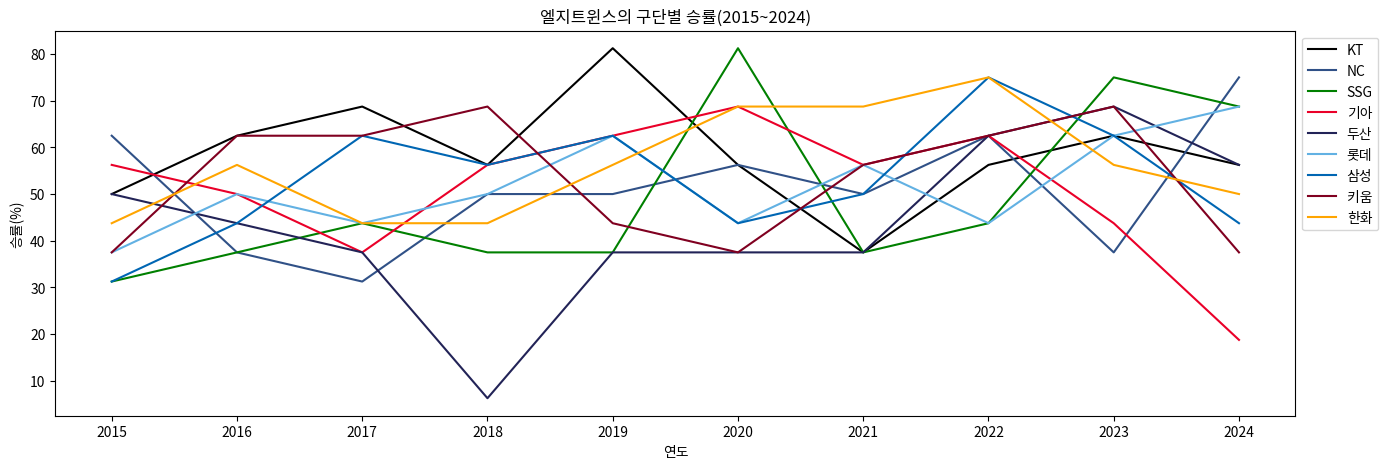

In [66]:
x_val = df_team_win_pivot.columns.get_level_values(1) #X축(Year)
label_val = list(df_team_win_pivot.index)   #범례(team)
colors = ['black', '#305187', 'green', '#EA0029', '#222357', '#62B1E3', '#0066B3', '#800020', 'orange']

plt.figure(figsize=(16, 5))

for i in range(len(df_team_win_pivot)):
    color = colors[i % len(colors)]
    plt.plot(x_val, df_team_win_pivot.iloc[i, :].values, label=label_val[i], color=color)

plt.xticks(range(2015, 2025))
plt.title("엘지트윈스의 구단별 승률(2015~2024)")
plt.xlabel("연도")
plt.ylabel("승률(%)")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

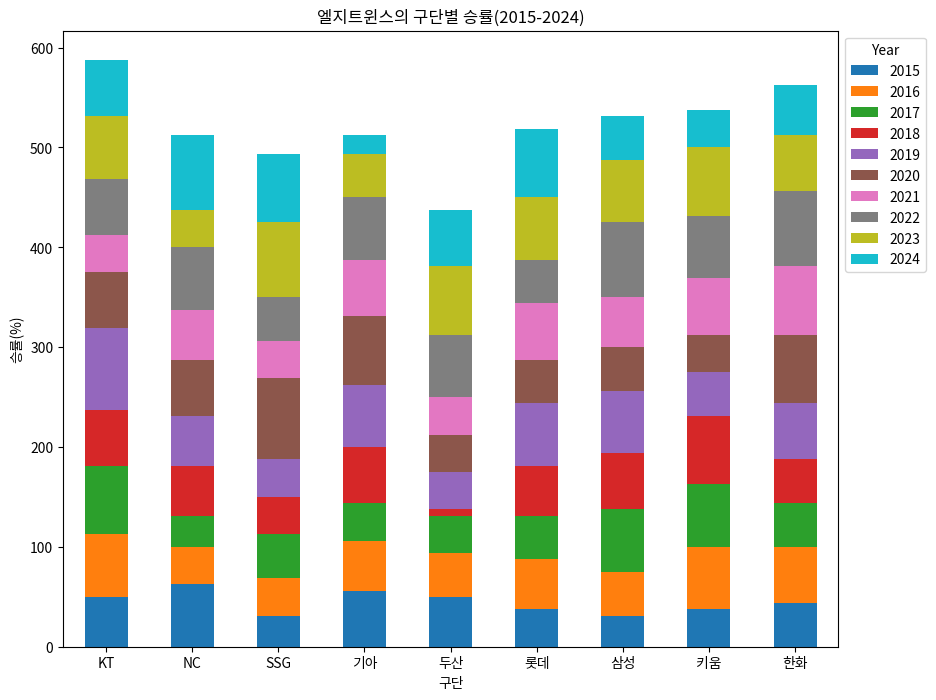

In [67]:
label = list(df_team_win_pivot.columns.get_level_values(1))

ax = df_team_win_pivot.plot(kind='bar', stacked=True, figsize=(10, 8))
plt.xticks(rotation=0)
ax.legend(labels=label, title='Year', bbox_to_anchor=(1,1))
ax.set_title('엘지트윈스의 구단별 승률(2015-2024)')
ax.set_xlabel('구단')
ax.set_ylabel('승률(%)')
plt.show()

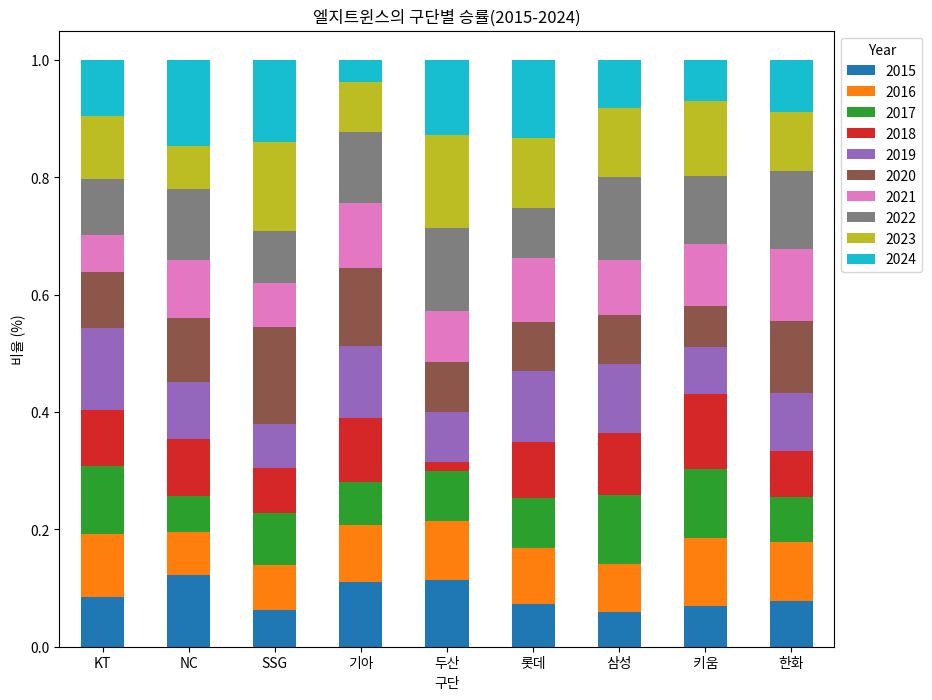

In [ ]:
import matplotlib.pyplot as plt

#각 행을 1로 기준으로 변환 (비율 계산)
df_team_win_pivot_normalized = df_team_win_pivot.div(df_team_win_pivot.sum(axis=1), axis=0)

#연도별 라벨 가져오기
label = list(df_team_win_pivot.columns.get_level_values(1))

# 막대 그래프 그리기
ax = df_team_win_pivot_normalized.plot(kind='bar', stacked=True, figsize=(10, 8))
plt.xticks(rotation=0)
ax.legend(labels=label, title='Year', bbox_to_anchor=(1,1), colors=colors)
ax.set_title('엘지트윈스의 구단별 승률(2015-2024)')
ax.set_xlabel('구단')
ax.set_ylabel('비율 (%)')
plt.show()

In [70]:
df_team_win_list = []

#구단명 목록
teams = ['KT', 'NC', 'SSG', '기아', '두산', '롯데', '삼성', '키움', '한화']

for team in teams:
    #각 팀에 대해 데이터 필터링
    df_team_win_team = df_team_win.query(f"team == '{team}'")
    
    #승률 차이 담을 새 컬럼 추가
    df_team_win_team[team] = 0
    df_team_win_team[team] = df_team_win_team[team].astype(float)
    
    #승률 차이 계산
    for i in range(len(df_team_win_team)-1):
        df_team_win_team.iloc[i+1, -1] = df_team_win_team.iloc[i+1, 1] - df_team_win_team.iloc[i, 1]
    
    #리스트에 추가
    df_team_win_list.append(df_team_win_team[[team]])

#결합
df_team_win_sub = pd.concat(df_team_win_list, axis=1)

#'연도' 컬럼 추가
df_team_win_sub['year'] = list(range(2015, 2025))
df_team_win_sub.set_index('year', inplace=True)

df_team_win_sub

C:\Users\User\AppData\Local\Temp\ipykernel_26588\89484095.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_team_win_team[team] = 0
C:\Users\User\AppData\Local\Temp\ipykernel_26588\89484095.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_team_win_team[team] = df_team_win_team[team].astype(float)
C:\Users\User\AppData\Local\Temp\ipykernel_26588\89484095.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

,KT,NC,SSG,기아,두산,롯데,삼성,키움,한화
year,,,,,,,,,
2015,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016,12.50,-25.00,6.25,-6.25,-6.25,12.50,12.50,25.00,12.50
2017,6.25,-6.25,6.25,-12.50,-6.25,-6.25,18.75,0.00,-12.50
2018,-12.50,18.75,-6.25,18.75,-31.25,6.25,-6.25,6.25,0.00
2019,25.00,0.00,0.00,6.25,31.25,12.50,6.25,-25.00,12.50
2020,-25.00,6.25,43.75,6.25,0.00,-18.75,-18.75,-6.25,12.50
2021,-18.75,-6.25,-43.75,-12.50,0.00,12.50,6.25,18.75,0.00
2022,18.75,12.50,6.25,6.25,25.00,-12.50,25.00,6.25,6.25
2023,6.25,-25.00,31.25,-18.75,6.25,18.75,-12.50,6.25,-18.75


In [71]:
teams = ['KT', 'NC', 'SSG', '기아', '두산', '롯데', '삼성', '키움', '한화']
downCounts = {}

for team in teams:
    downCounts[team] = len(df_team_win_sub.query(f"{team} < 0")[team])

downCounts

{'KT': 4,
 'NC': 4,
 'SSG': 3,
 '기아': 5,
 '두산': 4,
 '롯데': 3,
 '삼성': 4,
 '키움': 3,
 '한화': 3}

In [72]:
#구단명 목록
teams = ['KT', 'NC', 'SSG', '기아', '두산', '롯데', '삼성', '키움', '한화']

downCounts = {}
upCounts = {}

#전년도 대비 승률 음수
for team in teams:
    downCounts[team] = len(df_team_win_sub.query(f"{team} < 0")[team])

#전년도 대비 승률 양수
for team in teams:
    upCounts[team] = len(df_team_win_sub.query(f"{team} > 0")[team])

print(downCounts)
print(upCounts)

{'KT': 4, 'NC': 4, 'SSG': 3, '기아': 5, '두산': 4, '롯데': 3, '삼성': 4, '키움': 3, '한화': 3}
{'KT': 5, 'NC': 4, 'SSG': 5, '기아': 4, '두산': 3, '롯데': 6, '삼성': 5, '키움': 5, '한화': 4}


In [74]:
team = {
    'down': downCounts,
    'up': upCounts
}
columns = ['down' ,'up']
index = ['KT', 'NC', 'SSG', '기아', '두산', '롯데', '삼성', '키움', '한화']

df_team_win_updown = pd.DataFrame(team, columns=columns, index=index)
df_team_win_updown

,down,up
KT,4,5
NC,4,4
SSG,3,5
기아,5,4
두산,4,3
롯데,3,6
삼성,4,5
키움,3,5
한화,3,4


In [ ]:
x = np.arange(len(df.index))

plt.figure(figsize=(10, 6))

w = 0.4
plt.bar(x-w/2, df['H'], width=w, label='H', color='r', alpha=0.4)
plt.bar(x+w/2, df['A'], width=w, label='A', color='b', alpha=0.4)

plt.xticks(ticks=x, labels=df.index)
plt.title("2025년 구단별 홈과 원정 승률 예측 비교", pad=10, weight='bold')
plt.xlabel("구단", labelpad=10)
plt.ylabel("승률(%)", labelpad=10)

plt.legend()
plt.show()

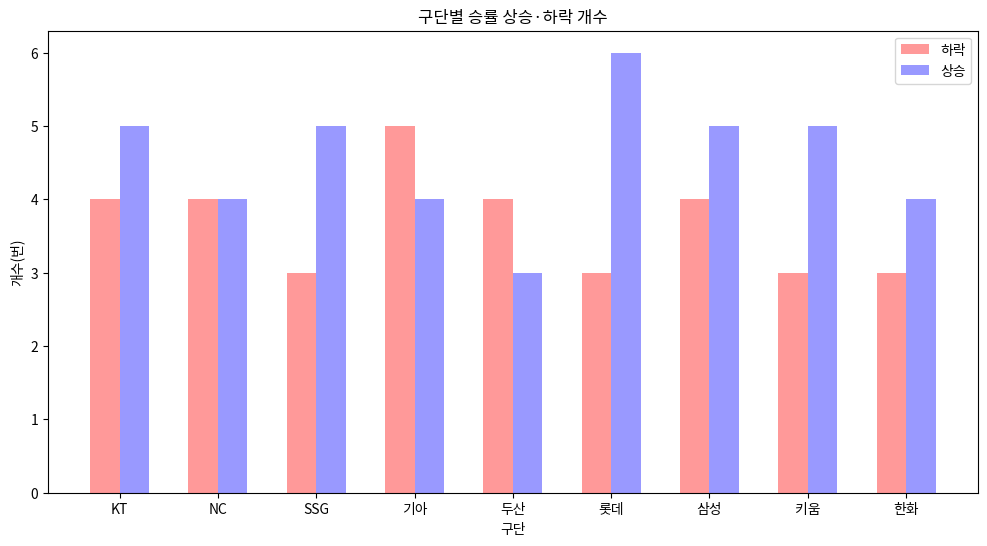

In [85]:
x = np.arange(len(df_team_win_updown.index))

plt.figure(figsize=(12,6))

w=0.3
plt.bar(x-w/2, df_team_win_updown['down'], width=w, label='하락', color='r', alpha=0.4)
plt.bar(x+w/2, df_team_win_updown['up'], width=w, label='상승', color='b', alpha=0.4)

plt.xticks(ticks=x, labels=df_team_win_updown.index)
plt.title("구단별 승률 상승·하락 개수")
plt.xlabel('구단')
plt.ylabel('개수(번)')
plt.legend()
plt.show()

---

In [109]:
#컬럼 추가
selected_features.append('G')   #출장
selected_features.append('GS')  #게임수
selected_features.append('W')   #승
selected_features.append('L')   #패
selected_features.append('winning_rate') #승률

In [110]:
selected_features

['RS',
 'OPS',
 'ERA',
 'RS9',
 'AVG',
 'R',
 'S',
 'IP',
 'WHIP',
 'ER',
 'HR',
 'SO',
 'H',
 'SF',
 'OBP',
 'G',
 'GS',
 'W',
 'L',
 'winning_rate']

# 2. 기아타이거즈

## (1) 전체

In [111]:
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

where_list = ['H', 'N'] #홈, 원정
df_kia_list = []    #홈, 원정 데이터프레임 담을 리스트

for where in where_list:
    url = 'https://statiz.sporki.com/stats/?m=team&m2=pitching&m3=situation1&so=s_year&ob=&year=2024&sy=2015&ey=2024&te=5002&po=&lt=10100&reg=&pe=&ds=&de=&we=&hr=&ha={}&ct=2&st=&vp=&bo=&pt=&pp=&ii=&vc=&um=&oo=&rr=&sc=&bc=&ba=&li=&as=&ae=&pl=&gc=&lr=&pr=50&ph=&hs=&us=&na=&ls=&sf1=&sk1=&sv1=&sf2=&sk2=&sv2='.format(where)

    #페이지 열기
    driver.get(url)

    #해당 클래스가 포함된 div가 나타날 때까지 대기 (최대 10초)
    try:
        div = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, "table_type01"))
        )
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        div_content = soup.find('div', class_='table_type01 transverse_scroll cbox')

        if div_content:
            first_table = div_content.find('table') #첫 번째 table 태그만 가져옴

        #헤더 추출
        headers = [th.text.strip() for th in first_table.find_all("th")]

        #데이터프레임 컬럼을 만들기 위해 불필요한 헤더 삭제
        rm = ['비율', 'Year']    #삭제할 헤더명
        idx = [i for i, x in enumerate(headers) if x in rm] #삭제할 헤더 index

        columns = [x for i, x in enumerate(headers) if i not in idx]    #삭제 후 남은 헤더
        #columns[0] = 'Year' #컬럼명 변경: 정렬▲ → Year

        columns = np.array(columns)

        #각 컬럼값
        tr = div_content.find("tbody").find_all('tr')

        rows = []   #각 컬럼값 담을 리스트

        for tr in first_table.find('tbody').find_all('tr'):
            cells = [td.text.strip() for td in tr.find_all('td')]
            rows.append(cells)

        #for i in range(len(rows)):
        #    rows[i] = rows[i][3:]   #불필요한 컬럼값 삭제

        df = pd.DataFrame(rows, columns=columns)    #데이터프레임 생성
        df_kia_list.append(df)  #생성한 데이터프레임 리스트에 추가

    except Exception as e:
        print("요소를 찾을 수 없음:", e)

    #print(url)

df_kia = pd.concat(df_kia_list) #3개의 데이터프레임(전체, 홈, 원정) 결합

df_kia = df_kia.iloc[:, 3:]

#컬럼 순서 변경: 헤더 가져올 때 순서가 변경됨
col_list = list(df_kia.columns)
col_list[0] = 'year'
col_list[-5:] = ['WHIP', 'AVG', 'OBP', 'OPS', 'ERA']
df_kia.columns = col_list

#데이터타입 변경
df_kia = df_kia.astype(float)

#연도 데이터 타입 정수형으로 변경
df_kia.year = df_kia.year.astype(int)

#승률 데이터 추가
df_kia['winning_rate'] = (df_kia['W'] / df_kia['GS'] *100).round(2)

df_kia = df_kia[selected_features]

df_kia

,RS,OPS,ERA,RS9,AVG,R,S,IP,WHIP,ER,HR,SO,H,SF,OBP,G,GS,W,L,winning_rate
0,39.0,0.717,3.25,4.9,0.277,29.0,2.0,72.0,1.25,26.0,3.0,53.0,74.0,3.0,0.331,31.0,8.0,5.0,3.0,62.50
1,39.0,0.639,3.24,4.7,0.244,32.0,2.0,75.0,1.21,27.0,5.0,46.0,68.0,2.0,0.313,30.0,8.0,4.0,3.0,50.00
2,41.0,0.790,4.97,5.2,0.285,44.0,1.0,70.2,1.42,39.0,9.0,62.0,79.0,4.0,0.342,31.0,8.0,4.0,4.0,50.00
3,43.0,0.673,4.00,5.4,0.241,32.0,2.0,72.0,1.26,32.0,7.0,47.0,64.0,3.0,0.312,30.0,8.0,6.0,2.0,75.00
4,58.0,0.657,3.63,7.3,0.243,32.0,1.0,72.0,1.35,29.0,2.0,53.0,65.0,3.0,0.329,32.0,8.0,6.0,2.0,75.00
5,52.0,0.589,2.96,6.4,0.220,28.0,1.0,73.0,1.27,24.0,2.0,60.0,60.0,1.0,0.307,38.0,8.0,6.0,2.0,75.00
6,40.0,0.682,2.71,4.9,0.243,26.0,2.0,73.0,1.42,22.0,7.0,54.0,68.0,1.0,0.336,40.0,8.0,5.0,3.0,62.50
7,25.0,0.654,3.63,3.1,0.230,35.0,2.0,72.0,1.24,29.0,5.0,55.0,62.0,3.0,0.305,39.0,8.0,4.0,4.0,50.00
8,27.0,0.708,4.02,3.7,0.278,35.0,1.0,65.0,1.43,29.0,4.0,54.0,70.0,3.0,0.339,39.0,7.0,2.0,5.0,28.57
9,34.0,0.838,6.37,3.7,0.330,60.0,2.0,82.0,1.71,58.0,7.0,61.0,110.0,6.0,0.388,48.0,9.0,2.0,7.0,22.22


In [112]:
df_kia.reset_index(inplace=True)
df_kia

,index,RS,OPS,ERA,RS9,AVG,R,S,IP,WHIP,...,HR,SO,H,SF,OBP,G,GS,W,L,winning_rate
0,0,39.0,0.717,3.25,4.9,0.277,29.0,2.0,72.0,1.25,...,3.0,53.0,74.0,3.0,0.331,31.0,8.0,5.0,3.0,62.50
1,1,39.0,0.639,3.24,4.7,0.244,32.0,2.0,75.0,1.21,...,5.0,46.0,68.0,2.0,0.313,30.0,8.0,4.0,3.0,50.00
2,2,41.0,0.790,4.97,5.2,0.285,44.0,1.0,70.2,1.42,...,9.0,62.0,79.0,4.0,0.342,31.0,8.0,4.0,4.0,50.00
3,3,43.0,0.673,4.00,5.4,0.241,32.0,2.0,72.0,1.26,...,7.0,47.0,64.0,3.0,0.312,30.0,8.0,6.0,2.0,75.00
4,4,58.0,0.657,3.63,7.3,0.243,32.0,1.0,72.0,1.35,...,2.0,53.0,65.0,3.0,0.329,32.0,8.0,6.0,2.0,75.00
5,5,52.0,0.589,2.96,6.4,0.220,28.0,1.0,73.0,1.27,...,2.0,60.0,60.0,1.0,0.307,38.0,8.0,6.0,2.0,75.00
6,6,40.0,0.682,2.71,4.9,0.243,26.0,2.0,73.0,1.42,...,7.0,54.0,68.0,1.0,0.336,40.0,8.0,5.0,3.0,62.50
7,7,25.0,0.654,3.63,3.1,0.230,35.0,2.0,72.0,1.24,...,5.0,55.0,62.0,3.0,0.305,39.0,8.0,4.0,4.0,50.00
8,8,27.0,0.708,4.02,3.7,0.278,35.0,1.0,65.0,1.43,...,4.0,54.0,70.0,3.0,0.339,39.0,7.0,2.0,5.0,28.57
9,9,34.0,0.838,6.37,3.7,0.330,60.0,2.0,82.0,1.71,...,7.0,61.0,110.0,6.0,0.388,48.0,9.0,2.0,7.0,22.22


In [174]:
df_kia_winning_rate = pd.concat([
    df_kia[['winning_rate']].iloc[:10].reset_index()[['winning_rate']],
    df_kia[['winning_rate']].iloc[10:].reset_index()[['winning_rate']]
], axis=1)

#index 변경
index = range(2015, 2025)
df_kia_winning_rate.index = index

#columns 변경
columns = ['H', 'A']
df_kia_winning_rate.columns = columns

df_kia_winning_rate

,H,A
2015,62.50,50.00
2016,50.00,50.00
2017,50.00,25.00
2018,75.00,37.50
2019,75.00,50.00
2020,75.00,62.50
2021,62.50,50.00
2022,50.00,75.00
2023,28.57,55.56
2024,22.22,14.29


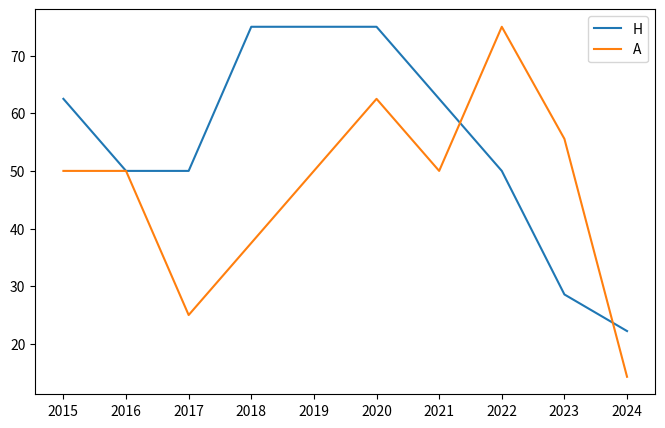

In [185]:
ax = df_kia_winning_rate.plot(figsize=(8,5))
plt.xticks(range(2015,2025))
plt.show()

In [175]:
df_kia_winning_rate.describe()

,H,A
count,10.000000,10.000000
mean,55.079000,46.985000
std,18.739474,17.568012
min,22.220000,14.290000
25%,50.000000,40.625000
50%,56.250000,50.000000
75%,71.875000,54.170000
max,75.000000,75.000000


2025년 예측 승률: 43.45%


c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


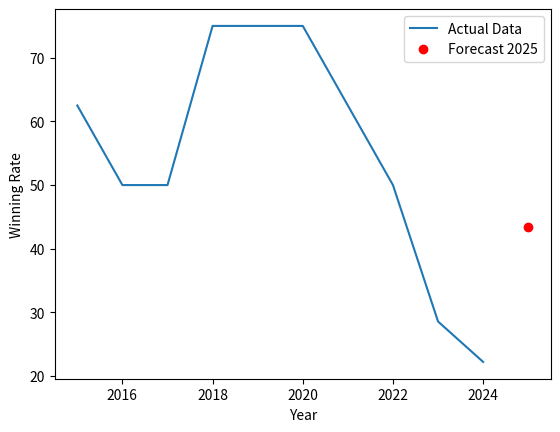

In [203]:
import pandas as pd
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

# 데이터 준비
data = {
    'year': [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'RS': [39.0, 39.0, 41.0, 43.0, 58.0, 52.0, 40.0, 25.0, 27.0, 34.0],
    'OPS': [0.717, 0.639, 0.790, 0.673, 0.657, 0.589, 0.682, 0.654, 0.708, 0.838],
    'ERA': [3.25, 3.24, 4.97, 4.00, 3.63, 2.96, 2.71, 3.63, 4.02, 6.37],
    'RS9': [4.9, 4.7, 5.2, 5.4, 7.3, 6.4, 4.9, 3.1, 3.7, 3.7],
    'AVG': [0.277, 0.244, 0.285, 0.241, 0.243, 0.220, 0.243, 0.230, 0.278, 0.330],
    'R': [29.0, 32.0, 44.0, 32.0, 32.0, 28.0, 26.0, 35.0, 35.0, 60.0],
    'S': [2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0],
    'IP': [72.0, 75.0, 70.2, 72.0, 72.0, 73.0, 73.0, 72.0, 65.0, 82.0],
    'WHIP': [1.25, 1.21, 1.42, 1.26, 1.35, 1.27, 1.42, 1.24, 1.43, 1.71],
    'ER': [26.0, 27.0, 39.0, 32.0, 29.0, 24.0, 22.0, 29.0, 29.0, 58.0],
    'HR': [3.0, 5.0, 9.0, 7.0, 2.0, 2.0, 7.0, 5.0, 4.0, 7.0],
    'SO': [53.0, 46.0, 62.0, 47.0, 53.0, 60.0, 54.0, 55.0, 54.0, 61.0],
    'H': [74.0, 68.0, 79.0, 64.0, 65.0, 60.0, 68.0, 62.0, 70.0, 110.0],
    'SF': [3.0, 2.0, 4.0, 3.0, 3.0, 1.0, 1.0, 3.0, 3.0, 6.0],
    'OBP': [0.331, 0.313, 0.342, 0.312, 0.329, 0.307, 0.336, 0.305, 0.339, 0.388],
    'G': [31.0, 30.0, 31.0, 30.0, 32.0, 38.0, 40.0, 39.0, 39.0, 48.0],
    'GS': [8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 7.0, 9.0],
    'W': [5.0, 4.0, 4.0, 6.0, 6.0, 6.0, 5.0, 4.0, 2.0, 2.0],
    'L': [3.0, 3.0, 4.0, 2.0, 2.0, 2.0, 3.0, 4.0, 5.0, 7.0],
    'winning_rate': [62.50, 50.00, 50.00, 75.00, 75.00, 75.00, 62.50, 50.00, 28.57, 22.22]
}

df_kiaH = pd.DataFrame(data)
df_kiaH.set_index('year', inplace=True)

# VAR 모델 학습
model = VAR(df_kiaH)  # 모든 컬럼을 사용
model_fitted = model.fit(maxlags=1)  # 최적의 lag 수 설정

# 2025년 예측
forecast = model_fitted.forecast(df_kiaH.values[-1:], steps=1)
forecast_df = pd.DataFrame(forecast, columns=df_kiaH.columns, index=[2025])

print(f"2025년 예측 승률: {forecast[0][-1]:.2f}%")

# 예측 결과 시각화
plt.plot(df_kiaH.index, df_kiaH['winning_rate'], label='Actual Data')
plt.plot(2025, forecast_df['winning_rate'].values[0], 'ro', label='Forecast 2025')
plt.xlabel('Year')
plt.ylabel('Winning Rate')
plt.legend()
plt.show()

2025년 예측 승률: 67.70%


c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


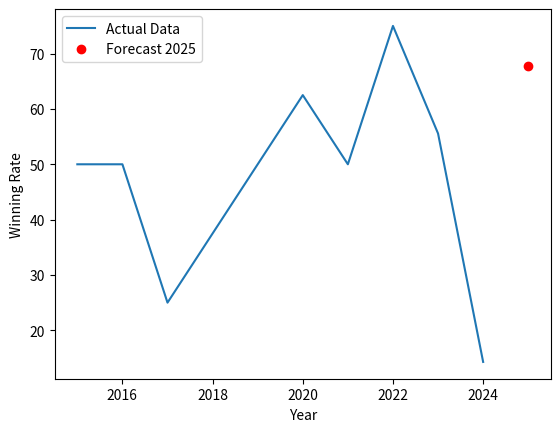

In [208]:
import pandas as pd
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

# df_kiaA 데이터 준비
data_kiaA = {
    'year': [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'RS': [38.0, 42.0, 47.0, 57.0, 45.0, 57.0, 43.0, 59.0, 57.0, 31.0],
    'OPS': [0.766, 0.786, 0.880, 0.870, 0.732, 0.787, 0.632, 0.722, 0.771, 0.921],
    'ERA': [5.27, 5.25, 7.51, 7.52, 5.69, 4.83, 2.71, 2.83, 4.79, 6.63],
    'RS9': [4.9, 5.4, 6.2, 7.7, 6.0, 7.4, 5.6, 7.6, 6.7, 4.9],
    'AVG': [0.263, 0.258, 0.313, 0.318, 0.298, 0.275, 0.230, 0.247, 0.306, 0.353],
    'R': [43.0, 45.0, 57.0, 59.0, 46.0, 46.0, 24.0, 23.0, 44.0, 49.0],
    'S': [2.0, 3.0, 1.0, 1.0, 2.0, 2.0, 0.0, 2.0, 2.0, 1.0],
    'IP': [70.0, 70.1, 68.1, 67.0, 68.0, 69.0, 69.2, 70.0, 77.0, 57.0],
    'WHIP': [1.40, 1.36, 1.68, 1.87, 1.50, 1.48, 1.33, 1.31, 1.68, 2.02],
    'ER': [41.0, 41.0, 57.0, 56.0, 43.0, 37.0, 21.0, 22.0, 41.0, 42.0],
    'HR': [9.0, 10.0, 10.0, 7.0, 3.0, 11.0, 2.0, 9.0, 6.0, 5.0],
    'SO': [60.0, 60.0, 46.0, 44.0, 54.0, 54.0, 48.0, 52.0, 58.0, 39.0],
    'H': [69.0, 69.0, 89.0, 89.0, 81.0, 77.0, 59.0, 65.0, 96.0, 83.0],
    'SF': [2.0, 3.0, 4.0, 4.0, 2.0, 2.0, 0.0, 1.0, 3.0, 5.0],
    'OBP': [0.346, 0.337, 0.384, 0.402, 0.361, 0.337, 0.339, 0.323, 0.370, 0.427],
    'G': [34.0, 36.0, 37.0, 33.0, 34.0, 35.0, 34.0, 41.0, 49.0, 28.0],
    'GS': [8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 9.0, 7.0],
    'W': [4.0, 4.0, 2.0, 3.0, 4.0, 5.0, 4.0, 6.0, 5.0, 1.0],
    'L': [4.0, 4.0, 6.0, 5.0, 4.0, 3.0, 3.0, 2.0, 4.0, 6.0],
    'winning_rate': [50.00, 50.00, 25.00, 37.50, 50.00, 62.50, 50.00, 75.00, 55.56, 14.29]
}

df_kiaA = pd.DataFrame(data_kiaA)
df_kiaA.set_index('year', inplace=True)

# VAR 모델 학습
model_kiaA = VAR(df_kiaA)  # 모든 컬럼을 사용
model_fitted_kiaA = model_kiaA.fit(maxlags=1)  # 최적의 lag 수 설정

# 2025년 예측
forecast_kiaA = model_fitted_kiaA.forecast(df_kiaA.values[-1:], steps=1)
forecast_df_kiaA = pd.DataFrame(forecast_kiaA, columns=df_kiaA.columns, index=[2025])

print(f"2025년 예측 승률: {forecast_kiaA[0][-1]:.2f}%")

# 예측 결과 시각화
plt.plot(df_kiaA.index, df_kiaA['winning_rate'], label='Actual Data')
plt.plot(2025, forecast_df_kiaA['winning_rate'].values[0], 'ro', label='Forecast 2025')
plt.xlabel('Year')
plt.ylabel('Winning Rate')
plt.legend()
plt.show()


---

In [113]:
df_kiaH = df_kia.iloc[:10, 1:]  #홈
df_kiaA = df_kia.iloc[10:, 1:]  #원정

---

In [114]:
from sklearn.linear_model import LinearRegression

In [169]:
df_kiaH[['G', 'GS', 'W', 'L']].describe()

,G,GS,W,L
count,10.00000,10.000000,10.000000,10.000000
mean,35.80000,8.000000,4.400000,3.500000
std,5.95912,0.471405,1.505545,1.581139
min,30.00000,7.000000,2.000000,2.000000
25%,31.00000,8.000000,4.000000,2.250000
50%,35.00000,8.000000,4.500000,3.000000
75%,39.00000,8.000000,5.750000,4.000000
max,48.00000,9.000000,6.000000,7.000000


In [136]:
#홈
game = np.array(df_kiaH[['G', 'GS', 'W', 'L']]) #(출장, 게임, 승, 패)
record = np.array(df_kiaH.iloc[:, :-5]) #기록(RS, OPS, ERA, RS9, AVG, R< S, IP, WHIP, ER, HR, SO, H, SF, OBP)
winning_rate = np.array(df_kiaH['winning_rate']) #승률

x_game = game   #게임수
y_record = record   #기록(RS, OPS, ERA, RS9, AVG, R< S, IP, WHIP, ER, HR, SO, H, SF, OBP)

#기록 예측 모델
model_record = LinearRegression()   #생성
model_record.fit(x_game, y_record)   #학습

#2013년 기록 예측
pred_record = model_record.predict([[35, 8, 4, 4]])[0]  #df_kiaH.G.mean(), df_kia.GS.mean(), df_kiaH.W.mean(), df_kiaH.L.mean()
pred_RS, pred_OPS, pred_ERA, pred_RS9, pred_AVG, pred_R, pred_S, pred_IP, pred_WHIP, pred_ER, pred_HR, pred_SO, pred_H, pred_SF, pred_OBP = pred_record

#승률 예측 모델
x = record
y = winning_rate
model_winning_rate = LinearRegression()
model_winning_rate.fit(x, y)

#예측 데이터
pred_x = np.array([[
    pred_RS, pred_OPS, pred_ERA, pred_RS9, pred_AVG,
    pred_R, pred_S, pred_IP, pred_WHIP, pred_ER,
    pred_HR, pred_SO, pred_H, pred_SF, pred_OBP
]])

#승률 예측
predicted_kiaH = model_winning_rate.predict(pred_x)[0]
print(f"2025년 승률 예측: {predicted_kiaH:.2f}")

2025년 승률 예측: 50.11


In [121]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 첫 번째 모델(기록 예측)의 평가
y_pred_record = model_record.predict(x_game)

r2_record = r2_score(y_record, y_pred_record)
mse_record = mean_squared_error(y_record, y_pred_record)
mae_record = mean_absolute_error(y_record, y_pred_record)

print(f"기록 예측 모델 평가:")
print(f"R² Score: {r2_record:.4f}")
print(f"MSE: {mse_record:.4f}")
print(f"MAE: {mae_record:.4f}\n")

# 두 번째 모델(승률 예측)의 평가
y_pred_wr = model_winning_rate.predict(x)

r2_wr = r2_score(y, y_pred_wr)
mse_wr = mean_squared_error(y, y_pred_wr)
mae_wr = mean_absolute_error(y, y_pred_wr)

print(f"승률 예측 모델 평가:")
print(f"R² Score: {r2_wr:.4f}")
print(f"MSE: {mse_wr:.4f}")
print(f"MAE: {mae_wr:.4f}")

기록 예측 모델 평가:
R² Score: 0.7324
MSE: 6.1714
MAE: 1.2701

승률 예측 모델 평가:
R² Score: 1.0000
MSE: 0.0000
MAE: 0.0000


In [137]:
df_kiaA.G.mean(), df_kiaA.GS.mean(), df_kiaA.W.mean(), df_kiaA.L.mean()

(36.1, 8.0, 3.8, 4.1)

In [138]:
#원정
game = np.array(df_kiaA[['G', 'GS', 'W', 'L']]) #(출장, 게임, 승, 패)
record = np.array(df_kiaA.iloc[:, :-5]) #기록(RS, OPS, ERA, RS9, AVG, R< S, IP, WHIP, ER, HR, SO, H, SF, OBP)
winning_rate = np.array(df_kiaA['winning_rate']) #승률

x_game = game   #게임수
y_record = record   #기록(RS, OPS, ERA, RS9, AVG, R< S, IP, WHIP, ER, HR, SO, H, SF, OBP)

#기록 예측 모델
model_record = LinearRegression()   #생성
model_record.fit(x_game, y_record)   #학습

#2013년 기록 예측
pred_record = model_record.predict([[36, 8, 4, 4]])[0]
pred_RS, pred_OPS, pred_ERA, pred_RS9, pred_AVG, pred_R, pred_S, pred_IP, pred_WHIP, pred_ER, pred_HR, pred_SO, pred_H, pred_SF, pred_OBP = pred_record

#승률 예측 모델
x = record
y = winning_rate
model_winning_rate = LinearRegression()
model_winning_rate.fit(x, y)

#예측 데이터
pred_x = np.array([[
    pred_RS, pred_OPS, pred_ERA, pred_RS9, pred_AVG,
    pred_R, pred_S, pred_IP, pred_WHIP, pred_ER,
    pred_HR, pred_SO, pred_H, pred_SF, pred_OBP
]])

#승률 예측
predicted_kiaA = model_winning_rate.predict(pred_x)[0]
print(f"2013년 승률 예측: {predicted_kiaH:.2f}")

2013년 승률 예측: 50.11


## (2) 화요일

In [569]:
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

day_list = [0, 2, 3, 4, 5, 6] #화~토
df_kia_day_list = []    #화~토 데이터프레임 담을 리스트

for day in day_list:
    url = 'https://statiz.sporki.com/stats/?m=team&m2=pitching&m3=situation1&so=s_year&ob=&year=2024&sy=2015&ey=2024&te=5002&po=&lt=10100&reg=&pe=&ds=&de=&we={}&hr=&ha=&ct=2&st=&vp=&bo=&pt=&pp=&ii=&vc=&um=&oo=&rr=&sc=&bc=&ba=&li=&as=&ae=&pl=&gc=&lr=&pr=50&ph=&hs=&us=&na=&ls=&sf1=&sk1=&sv1=&sf2=&sk2=&sv2='.format(day)

    #페이지 열기
    driver.get(url)

    #해당 클래스가 포함된 div가 나타날 때까지 대기 (최대 10초)
    try:
        div = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, "table_type01"))
        )
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        div_content = soup.find('div', class_='table_type01 transverse_scroll cbox')

        if div_content:
            first_table = div_content.find('table') #첫 번째 table 태그만 가져옴

        #헤더 추출
        headers = [th.text.strip() for th in first_table.find_all("th")]

        #데이터프레임 컬럼을 만들기 위해 불필요한 헤더 삭제
        rm = ['Rank', 'Season', 'Year▲', '비율', 'Year']    #삭제할 헤더명
        idx = [i for i, x in enumerate(headers) if x in rm] #삭제할 헤더 index

        columns = [x for i, x in enumerate(headers) if i not in idx]    #삭제 후 남은 헤더
        columns[0] = 'Year' #컬럼명 변경: 정렬▲ → Year

        columns = np.array(columns)

        #각 컬럼값
        tr = div_content.find("tbody").find_all('tr')

        rows = []   #각 컬럼값 담을 리스트

        for tr in first_table.find('tbody').find_all('tr'):
            cells = [td.text.strip() for td in tr.find_all('td')]
            rows.append(cells)

        for i in range(len(rows)):
            rows[i] = rows[i][3:]   #불필요한 컬럼값 삭제

        df = pd.DataFrame(rows, columns=columns)    #데이터프레임 생성
        df_kia_day_list.append(df)  #생성한 데이터프레임 리스트에 추가

    except Exception as e:
        print("요소를 찾을 수 없음:", e)

    #print(url)

df_kia_day = pd.concat(df_kia_day_list) #3개의 데이터프레임(전체, 홈, 원정) 결합

#컬럼 순서 변경: 헤더 가져올 때 순서가 변경됨
col_list = list(df_kia_day.columns)
col_list[-5:] = ['WHIP', 'AVG', 'OBP', 'OPS', 'ERA']
df_kia_day.columns = col_list

#데이터타입 변경
df_kia_day = df_kia_day.astype(float)

#연도 데이터 타입 정수형으로 변경
df_kia_day.Year = df_kia_day.Year.astype(int)

#승률 데이터 추가
df_kia_day['winning_rate'] = (df_kia_day['W'] / df_kia_day['G'] *100).round(2)

df_kia_day = df_kia_day[selected_features]

df_kia_day.shape

(57, 12)

In [571]:
df_kia_day.reset_index(inplace=True)

In [576]:
df_kia_day.query("index == 0")

,index,RS,RS9,HR,SF,H,OPS,AVG,OBP,WHIP,ER,Year,winning_rate
0,0,11.0,5.8,3.0,0.0,14.0,0.769,0.233,0.352,1.29,9.0,2015,11.11
10,0,25.0,5.9,1.0,1.0,28.0,0.547,0.206,0.268,1.00,10.0,2015,21.43
20,0,9.0,4.5,0.0,0.0,20.0,0.720,0.290,0.329,1.22,8.0,2015,16.67
30,0,16.0,5.5,4.0,2.0,43.0,0.999,0.381,0.433,2.00,22.0,2015,14.29
38,0,6.0,3.0,2.0,1.0,18.0,0.679,0.269,0.306,1.11,7.0,2016,16.67
47,0,5.0,1.8,1.0,2.0,23.0,0.741,0.267,0.369,1.48,12.0,2015,0.00


In [601]:
df_kia_sun = df_kia_day.iloc[:10, 1:]    #일요일
df_kia_tue = df_kia_day.iloc[10:20, 1:]  #화요일
df_kia_wed = df_kia_day.iloc[20:30, 1:]  #수요일
df_kia_thu = df_kia_day.iloc[30:38, 1:]  #목요일
df_kia_fri = df_kia_day.iloc[38:47, 1:]  #금요일
df_kia_sat = df_kia_day.iloc[47:, 1:]    #토요일

df_kia_sun.shape, df_kia_tue.shape, df_kia_wed.shape, df_kia_thu.shape, df_kia_fri.shape, df_kia_sat.shape

((10, 12), (10, 12), (10, 12), (8, 12), (9, 12), (10, 12))

In [602]:
df_kia_weekdays = pd.concat([df_kia_tue, df_kia_wed, df_kia_thu], axis=0)   #주중 시리즈 결합
df_kia_weekends = pd.concat([df_kia_fri, df_kia_sat, df_kia_sun], axis=0)   #주말 시리즈 결합

df_kia_weekdays.shape, df_kia_weekends.shape

((28, 12), (29, 12))

In [608]:
#주중 시리즈
years = np.array(df_kia_weekdays[['Year']]) #연도
record = np.array(df_kia_weekdays.iloc[:, :-2]) #기록(RS, RS9, HR, SF, H, OPS, AVG, OBP, WHIP, ER)
winning_rate = np.array(df_kia_weekdays['winning_rate'])    #승률

In [611]:
df_kia_weekdays

,RS,RS9,HR,SF,H,OPS,AVG,OBP,WHIP,ER,Year,winning_rate
10,25.0,5.9,1.0,1.0,28.0,0.547,0.206,0.268,1.00,10.0,2015,21.43
11,15.0,3.6,4.0,0.0,36.0,0.720,0.254,0.333,1.41,19.0,2016,5.56
12,6.0,1.9,4.0,1.0,26.0,0.743,0.248,0.333,1.36,12.0,2017,7.14
13,12.0,6.8,1.0,1.0,25.0,0.936,0.347,0.478,2.69,18.0,2018,0.00
14,41.0,13.7,0.0,0.0,24.0,0.577,0.233,0.295,1.15,8.0,2019,25.00
15,27.0,6.8,1.0,0.0,37.0,0.700,0.261,0.348,1.53,17.0,2020,10.53
16,4.0,2.1,3.0,0.0,23.0,0.914,0.324,0.407,1.88,12.0,2021,0.00
17,15.0,5.0,2.0,2.0,29.0,0.745,0.276,0.345,1.48,14.0,2022,5.26
18,4.0,4.0,1.0,0.0,10.0,0.771,0.286,0.342,1.44,3.0,2023,20.00
19,15.0,4.1,2.0,2.0,53.0,0.930,0.366,0.447,2.24,30.0,2024,0.00


In [609]:
#기록 예측 모델
x_years = years #독립변수
y_record = np.column_stack((record))    #종속변수
model_reocrd = LinearRegression()   #생성
model_record.fit(x_years, y_record) #학습

ValueError: Found input variables with inconsistent numbers of samples: [28, 10]

# 3. 삼성라이온즈

In [461]:
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

where_list = ['H', 'N'] #홈, 원정
df_samsung_list = []    #홈, 원정 데이터프레임 담을 리스트

for where in where_list:
    url = 'https://statiz.sporki.com/stats/?m=team&m2=pitching&m3=situation1&so=s_year&ob=&year=2024&sy=2015&ey=2024&te=5002&po=&lt=10100&reg=&pe=&ds=&de=&we=&hr=&ha={}&ct=1&st=&vp=&bo=&pt=&pp=&ii=&vc=&um=&oo=&rr=&sc=&bc=&ba=&li=&as=&ae=&pl=&gc=&lr=&pr=50&ph=&hs=&us=&na=&ls=&sf1=&sk1=&sv1=&sf2=&sk2=&sv2='.format(where)

    #페이지 열기
    driver.get(url)

    #해당 클래스가 포함된 div가 나타날 때까지 대기 (최대 10초)
    try:
        div = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, "table_type01"))
        )
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        div_content = soup.find('div', class_='table_type01 transverse_scroll cbox')

        if div_content:
            first_table = div_content.find('table') #첫 번째 table 태그만 가져옴

        #헤더 추출
        headers = [th.text.strip() for th in first_table.find_all("th")]

        #데이터프레임 컬럼을 만들기 위해 불필요한 헤더 삭제
        rm = ['Rank', 'Season', 'Year▲', '비율', 'Year']    #삭제할 헤더명
        idx = [i for i, x in enumerate(headers) if x in rm] #삭제할 헤더 index

        columns = [x for i, x in enumerate(headers) if i not in idx]    #삭제 후 남은 헤더
        columns[0] = 'Year' #컬럼명 변경: 정렬▲ → Year

        columns = np.array(columns)

        #각 컬럼값
        tr = div_content.find("tbody").find_all('tr')

        rows = []   #각 컬럼값 담을 리스트

        for tr in first_table.find('tbody').find_all('tr'):
            cells = [td.text.strip() for td in tr.find_all('td')]
            rows.append(cells)

        for i in range(len(rows)):
            rows[i] = rows[i][3:]   #불필요한 컬럼값 삭제

        df = pd.DataFrame(rows, columns=columns)    #데이터프레임 생성
        df_samsung_list.append(df)  #생성한 데이터프레임 리스트에 추가

    except Exception as e:
        print("요소를 찾을 수 없음:", e)

    #print(url)

df_samsung = pd.concat(df_samsung_list) #3개의 데이터프레임(전체, 홈, 원정) 결합

#컬럼 순서 변경: 헤더 가져올 때 순서가 변경됨
col_list = list(df_samsung.columns)
col_list[-5:] = ['WHIP', 'AVG', 'OBP', 'OPS', 'ERA']
df_samsung.columns = col_list

#데이터타입 변경
df_samsung = df_samsung.astype(float)

#연도 데이터 타입 정수형으로 변경
df_samsung.Year = df_samsung.Year.astype(int)

#승률 데이터 추가
df_samsung['winning_rate'] = (df_samsung['W'] / df_samsung['G'] *100).round(2)

df_samsung = df_samsung[selected_features]

df_samsung.reset_index(inplace=True)

df_samsung.shape  #(20, 13)

(20, 13)

In [463]:
df_samsungH = df_samsung.iloc[:10, 1:]  #홈
df_samsungA = df_samsung.iloc[10:, 1:]  #원정

In [511]:
#홈
years = np.array(df_samsungH[['Year']]) #연도
record = np.array(df_samsungH.iloc[:, :-2]) #기록(RS, RS9, HR, SF, H, OPS, AVG, OBP, WHIP, ER)
winning_rate = np.array(df_samsungH['winning_rate'])    #승률

#기록 예측 모델
x_years = years #독립변수
y_record = np.column_stack((record))    #종속변수
model_record = LinearRegression()   #생성
model_record.fit(x_years, y_record) #학습

#2025년 기록 예측
pred_record = model_record.predict([[2025]])[0]
pred_RS, pred_RS9, pred_HR, pred_SF, pred_H, pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER = pred_record

#승률 예측 모델
x = np.column_stack((record))   #독립변수
y = winning_rate    #종속변수
model_wr = LinearRegression()   #생성
model_wr.fit(x, y)  #학습

#2025년 예측 데이터
pred_x = np.array([[
    pred_RS, pred_RS9, pred_HR, pred_SF, pred_H,
    pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER
]])

#승률 예측
predicted_samsungH = model_wr.predict(pred_x)[0]
print(f"2025년 삼성 라이온즈 상대 홈 예상 승률: {predicted_samsungH:.2f}%")

2025년 삼성 라이온즈 상대 홈 예상 승률: 14.30%


In [513]:
#홈
years = np.array(df_samsungA[['Year']]) #연도
record = np.array(df_samsungA.iloc[:, :-2]) #기록(RS, RS9, HR, SF, H, OPS, AVG, OBP, WHIP, ER)
winning_rate = np.array(df_samsungA['winning_rate'])    #승률

#기록 예측 모델
x_years = years #독립변수
y_record = np.column_stack((record))    #종속변수
model_record = LinearRegression()   #생성
model_record.fit(x_years, y_record) #학습

#2025년 기록 예측
pred_record = model_record.predict([[2025]])[0]
pred_RS, pred_RS9, pred_HR, pred_SF, pred_H, pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER = pred_record

#승률 예측 모델
x = np.column_stack((record))   #독립변수
y = winning_rate    #종속변수
model_wr = LinearRegression()   #생성
model_wr.fit(x, y)  #학습

#2025년 예측 데이터
pred_x = np.array([[
    pred_RS, pred_RS9, pred_HR, pred_SF, pred_H,
    pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER
]])

#승률 예측
predicted_samsungA = model_wr.predict(pred_x)[0]
print(f"2025년 삼성 라이온즈 상대 원정 예상 승률: {predicted_samsungA:.2f}%")

2025년 삼성 라이온즈 상대 원정 예상 승률: 12.09%


# 4. 두산 베어스

In [473]:
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

where_list = ['H', 'N'] #홈, 원정
df_doosan_list = []    #홈, 원정 데이터프레임 담을 리스트

for where in where_list:
    url = 'https://statiz.sporki.com/stats/?m=team&m2=pitching&m3=situation1&so=s_year&ob=&year=2024&sy=2015&ey=2024&te=5002&po=&lt=10100&reg=&pe=&ds=&de=&we=&hr=&ha={}&ct=6&st=&vp=&bo=&pt=&pp=&ii=&vc=&um=&oo=&rr=&sc=&bc=&ba=&li=&as=&ae=&pl=&gc=&lr=&pr=50&ph=&hs=&us=&na=&ls=&sf1=&sk1=&sv1=&sf2=&sk2=&sv2='.format(where)

    #페이지 열기
    driver.get(url)

    #해당 클래스가 포함된 div가 나타날 때까지 대기 (최대 10초)
    try:
        div = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, "table_type01"))
        )
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        div_content = soup.find('div', class_='table_type01 transverse_scroll cbox')

        if div_content:
            first_table = div_content.find('table') #첫 번째 table 태그만 가져옴

        #헤더 추출
        headers = [th.text.strip() for th in first_table.find_all("th")]

        #데이터프레임 컬럼을 만들기 위해 불필요한 헤더 삭제
        rm = ['Rank', 'Season', 'Year▲', '비율', 'Year']    #삭제할 헤더명
        idx = [i for i, x in enumerate(headers) if x in rm] #삭제할 헤더 index

        columns = [x for i, x in enumerate(headers) if i not in idx]    #삭제 후 남은 헤더
        columns[0] = 'Year' #컬럼명 변경: 정렬▲ → Year

        columns = np.array(columns)

        #각 컬럼값
        tr = div_content.find("tbody").find_all('tr')

        rows = []   #각 컬럼값 담을 리스트

        for tr in first_table.find('tbody').find_all('tr'):
            cells = [td.text.strip() for td in tr.find_all('td')]
            rows.append(cells)

        for i in range(len(rows)):
            rows[i] = rows[i][3:]   #불필요한 컬럼값 삭제

        df = pd.DataFrame(rows, columns=columns)    #데이터프레임 생성
        df_doosan_list.append(df)  #생성한 데이터프레임 리스트에 추가

    except Exception as e:
        print("요소를 찾을 수 없음:", e)

    #print(url)

df_doosan = pd.concat(df_doosan_list) #3개의 데이터프레임(전체, 홈, 원정) 결합

#컬럼 순서 변경: 헤더 가져올 때 순서가 변경됨
col_list = list(df_doosan.columns)
col_list[-5:] = ['WHIP', 'AVG', 'OBP', 'OPS', 'ERA']
df_doosan.columns = col_list

#데이터타입 변경
df_doosan = df_doosan.astype(float)

#연도 데이터 타입 정수형으로 변경
df_doosan.Year = df_doosan.Year.astype(int)

#승률 데이터 추가
df_doosan['winning_rate'] = (df_doosan['W'] / df_doosan['G'] *100).round(2)

df_doosan = df_doosan[selected_features]

df_doosan.reset_index(inplace=True)

df_doosanH = df_doosan.iloc[:10, 1:]  #홈
df_doosanA = df_doosan.iloc[10:, 1:]  #원정

In [514]:
#홈
years = np.array(df_doosanH[['Year']]) #연도
record = np.array(df_doosanH.iloc[:, :-2]) #기록(RS, RS9, HR, SF, H, OPS, AVG, OBP, WHIP, ER)
winning_rate = np.array(df_doosanH['winning_rate'])    #승률

#기록 예측 모델
x_years = years #독립변수
y_record = np.column_stack((record))    #종속변수
model_record = LinearRegression()   #생성
model_record.fit(x_years, y_record) #학습

#2025년 기록 예측
pred_record = model_record.predict([[2025]])[0]
pred_RS, pred_RS9, pred_HR, pred_SF, pred_H, pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER = pred_record

#승률 예측 모델
x = np.column_stack((record))   #독립변수
y = winning_rate    #종속변수
model_wr = LinearRegression()   #생성
model_wr.fit(x, y)  #학습

#2025년 예측 데이터
pred_x = np.array([[
    pred_RS, pred_RS9, pred_HR, pred_SF, pred_H,
    pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER
]])

#승률 예측
predicted_doosanH = model_wr.predict(pred_x)[0]
print(f"2025년 두산 베어스 상대 홈 예상 승률: {predicted_doosanH:.2f}%")

2025년 두산 베어스 상대 홈 예상 승률: 11.32%


In [515]:
#원정
years = np.array(df_doosanA[['Year']]) #연도
record = np.array(df_doosanA.iloc[:, :-2]) #기록(RS, RS9, HR, SF, H, OPS, AVG, OBP, WHIP, ER)
winning_rate = np.array(df_doosanA['winning_rate'])    #승률

#기록 예측 모델
x_years = years #독립변수
y_record = np.column_stack((record))    #종속변수
model_record = LinearRegression()   #생성
model_record.fit(x_years, y_record) #학습

#2025년 기록 예측
pred_record = model_record.predict([[2025]])[0]
pred_RS, pred_RS9, pred_HR, pred_SF, pred_H, pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER = pred_record

#승률 예측 모델
x = np.column_stack((record))   #독립변수
y = winning_rate    #종속변수
model_wr = LinearRegression()   #생성
model_wr.fit(x, y)  #학습

#2025년 예측 데이터
pred_x = np.array([[
    pred_RS, pred_RS9, pred_HR, pred_SF, pred_H,
    pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER
]])

#승률 예측
predicted_doosanA = model_wr.predict(pred_x)[0]
print(f"2025년 두산 베어스 상대 원정 예상 승률: {predicted_doosanA:.2f}%")

2025년 두산 베어스 상대 원정 예상 승률: 11.67%


# 5. SSG 랜더스

In [481]:
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

where_list = ['H', 'N'] #홈, 원정
df_SSG_list = []    #홈, 원정 데이터프레임 담을 리스트

for where in where_list:
    url = 'https://statiz.sporki.com/stats/?m=team&m2=pitching&m3=situation1&so=s_year&ob=&year=2024&sy=2015&ey=2024&te=5002&po=&lt=10100&reg=&pe=&ds=&de=&we=&hr=&ha={}&ct=9&st=&vp=&bo=&pt=&pp=&ii=&vc=&um=&oo=&rr=&sc=&bc=&ba=&li=&as=&ae=&pl=&gc=&lr=&pr=50&ph=&hs=&us=&na=&ls=&sf1=&sk1=&sv1=&sf2=&sk2=&sv2='.format(where)

    #페이지 열기
    driver.get(url)

    #해당 클래스가 포함된 div가 나타날 때까지 대기 (최대 10초)
    try:
        div = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, "table_type01"))
        )
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        div_content = soup.find('div', class_='table_type01 transverse_scroll cbox')

        if div_content:
            first_table = div_content.find('table') #첫 번째 table 태그만 가져옴

        #헤더 추출
        headers = [th.text.strip() for th in first_table.find_all("th")]

        #데이터프레임 컬럼을 만들기 위해 불필요한 헤더 삭제
        rm = ['Rank', 'Season', 'Year▲', '비율', 'Year']    #삭제할 헤더명
        idx = [i for i, x in enumerate(headers) if x in rm] #삭제할 헤더 index

        columns = [x for i, x in enumerate(headers) if i not in idx]    #삭제 후 남은 헤더
        columns[0] = 'Year' #컬럼명 변경: 정렬▲ → Year

        columns = np.array(columns)

        #각 컬럼값
        tr = div_content.find("tbody").find_all('tr')

        rows = []   #각 컬럼값 담을 리스트

        for tr in first_table.find('tbody').find_all('tr'):
            cells = [td.text.strip() for td in tr.find_all('td')]
            rows.append(cells)

        for i in range(len(rows)):
            rows[i] = rows[i][3:]   #불필요한 컬럼값 삭제

        df = pd.DataFrame(rows, columns=columns)    #데이터프레임 생성
        df_SSG_list.append(df)  #생성한 데이터프레임 리스트에 추가

    except Exception as e:
        print("요소를 찾을 수 없음:", e)

    #print(url)

df_SSG = pd.concat(df_SSG_list) #3개의 데이터프레임(전체, 홈, 원정) 결합

#컬럼 순서 변경: 헤더 가져올 때 순서가 변경됨
col_list = list(df_SSG.columns)
col_list[-5:] = ['WHIP', 'AVG', 'OBP', 'OPS', 'ERA']
df_SSG.columns = col_list

#데이터타입 변경
df_SSG = df_SSG.astype(float)

#연도 데이터 타입 정수형으로 변경
df_SSG.Year = df_SSG.Year.astype(int)

#승률 데이터 추가
df_SSG['winning_rate'] = (df_SSG['W'] / df_SSG['G'] *100).round(2)

df_SSG = df_SSG[selected_features]

df_SSG.reset_index(inplace=True)

df_SSGH = df_SSG.iloc[:10, 1:]  #홈
df_SSGA = df_SSG.iloc[10:, 1:]  #원정

In [516]:
#홈
years = np.array(df_SSGH[['Year']]) #연도
record = np.array(df_SSGH.iloc[:, :-2]) #기록(RS, RS9, HR, SF, H, OPS, AVG, OBP, WHIP, ER)
winning_rate = np.array(df_SSGH['winning_rate'])    #승률

#기록 예측 모델
x_years = years #독립변수
y_record = np.column_stack((record))    #종속변수
model_record = LinearRegression()   #생성
model_record.fit(x_years, y_record) #학습

#2025년 기록 예측
pred_record = model_record.predict([[2025]])[0]
pred_RS, pred_RS9, pred_HR, pred_SF, pred_H, pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER = pred_record

#승률 예측 모델
x = np.column_stack((record))   #독립변수
y = winning_rate    #종속변수
model_wr = LinearRegression()   #생성
model_wr.fit(x, y)  #학습

#2025년 예측 데이터
pred_x = np.array([[
    pred_RS, pred_RS9, pred_HR, pred_SF, pred_H,
    pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER
]])

#승률 예측
predicted_ssgH = model_wr.predict(pred_x)[0]
print(f"2025년 SSG 랜더스 상대 홈 예상 승률: {predicted_ssgH:.2f}%")

2025년 SSG 랜더스 상대 홈 예상 승률: 14.58%


In [517]:
#원정
years = np.array(df_SSGA[['Year']]) #연도
record = np.array(df_SSGA.iloc[:, :-2]) #기록(RS, RS9, HR, SF, H, OPS, AVG, OBP, WHIP, ER)
winning_rate = np.array(df_SSGA['winning_rate'])    #승률

#기록 예측 모델
x_years = years #독립변수
y_record = np.column_stack((record))    #종속변수
model_record = LinearRegression()   #생성
model_record.fit(x_years, y_record) #학습

#2025년 기록 예측
pred_record = model_record.predict([[2025]])[0]
pred_RS, pred_RS9, pred_HR, pred_SF, pred_H, pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER = pred_record

#승률 예측 모델
x = np.column_stack((record))   #독립변수
y = winning_rate    #종속변수
model_wr = LinearRegression()   #생성
model_wr.fit(x, y)  #학습

#2025년 예측 데이터
pred_x = np.array([[
    pred_RS, pred_RS9, pred_HR, pred_SF, pred_H,
    pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER
]])

#승률 예측
predicted_ssgA = model_wr.predict(pred_x)[0]
print(f"2025년 SSG 랜더스 상대 원정 예상 승률: {predicted_ssgA:.2f}%")

2025년 SSG 랜더스 상대 원정 예상 승률: 14.20%


# 6. 롯데 자이언츠

In [471]:
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

where_list = ['H', 'N'] #홈, 원정
df_lotte_list = []    #홈, 원정 데이터프레임 담을 리스트

for where in where_list:
    url = 'https://statiz.sporki.com/stats/?m=team&m2=pitching&m3=situation1&so=s_year&ob=&year=2024&sy=2015&ey=2024&te=5002&po=&lt=10100&reg=&pe=&ds=&de=&we=&hr=&ha={}&ct=3&st=&vp=&bo=&pt=&pp=&ii=&vc=&um=&oo=&rr=&sc=&bc=&ba=&li=&as=&ae=&pl=&gc=&lr=&pr=50&ph=&hs=&us=&na=&ls=&sf1=&sk1=&sv1=&sf2=&sk2=&sv2='.format(where)

    #페이지 열기
    driver.get(url)

    #해당 클래스가 포함된 div가 나타날 때까지 대기 (최대 10초)
    try:
        div = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, "table_type01"))
        )
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        div_content = soup.find('div', class_='table_type01 transverse_scroll cbox')

        if div_content:
            first_table = div_content.find('table') #첫 번째 table 태그만 가져옴

        #헤더 추출
        headers = [th.text.strip() for th in first_table.find_all("th")]

        #데이터프레임 컬럼을 만들기 위해 불필요한 헤더 삭제
        rm = ['Rank', 'Season', 'Year▲', '비율', 'Year']    #삭제할 헤더명
        idx = [i for i, x in enumerate(headers) if x in rm] #삭제할 헤더 index

        columns = [x for i, x in enumerate(headers) if i not in idx]    #삭제 후 남은 헤더
        columns[0] = 'Year' #컬럼명 변경: 정렬▲ → Year

        columns = np.array(columns)

        #각 컬럼값
        tr = div_content.find("tbody").find_all('tr')

        rows = []   #각 컬럼값 담을 리스트

        for tr in first_table.find('tbody').find_all('tr'):
            cells = [td.text.strip() for td in tr.find_all('td')]
            rows.append(cells)

        for i in range(len(rows)):
            rows[i] = rows[i][3:]   #불필요한 컬럼값 삭제

        df = pd.DataFrame(rows, columns=columns)    #데이터프레임 생성
        df_lotte_list.append(df)  #생성한 데이터프레임 리스트에 추가

    except Exception as e:
        print("요소를 찾을 수 없음:", e)

    #print(url)

df_lotte = pd.concat(df_lotte_list) #3개의 데이터프레임(전체, 홈, 원정) 결합

#컬럼 순서 변경: 헤더 가져올 때 순서가 변경됨
col_list = list(df_lotte.columns)
col_list[-5:] = ['WHIP', 'AVG', 'OBP', 'OPS', 'ERA']
df_lotte.columns = col_list

#데이터타입 변경
df_lotte = df_lotte.astype(float)

#연도 데이터 타입 정수형으로 변경
df_lotte.Year = df_lotte.Year.astype(int)

#승률 데이터 추가
df_lotte['winning_rate'] = (df_lotte['W'] / df_lotte['G'] *100).round(2)

df_lotte = df_lotte[selected_features]

df_lotte.reset_index(inplace=True)

df_lotteH = df_lotte.iloc[:10, 1:]  #홈
df_lotteA = df_lotte.iloc[10:, 1:]  #원정

In [518]:
#홈
years = np.array(df_lotteH[['Year']]) #연도
record = np.array(df_lotteH.iloc[:, :-2]) #기록(RS, RS9, HR, SF, H, OPS, AVG, OBP, WHIP, ER)
winning_rate = np.array(df_lotteH['winning_rate'])    #승률

#기록 예측 모델
x_years = years #독립변수
y_record = np.column_stack((record))    #종속변수
model_record = LinearRegression()   #생성
model_record.fit(x_years, y_record) #학습

#2025년 기록 예측
pred_record = model_record.predict([[2025]])[0]
pred_RS, pred_RS9, pred_HR, pred_SF, pred_H, pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER = pred_record

#승률 예측 모델
x = np.column_stack((record))   #독립변수
y = winning_rate    #종속변수
model_wr = LinearRegression()   #생성
model_wr.fit(x, y)  #학습

#2025년 예측 데이터
pred_x = np.array([[
    pred_RS, pred_RS9, pred_HR, pred_SF, pred_H,
    pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER
]])

#승률 예측
predicted_lotteH = model_wr.predict(pred_x)[0]
print(f"2025년 롯데 자이언츠 상대 홈 예상 승률: {predicted_lotteH:.2f}%")

2025년 롯데 자이언츠 상대 홈 예상 승률: 9.87%


In [519]:
#원정
years = np.array(df_lotteA[['Year']]) #연도
record = np.array(df_lotteA.iloc[:, :-2]) #기록(RS, RS9, HR, SF, H, OPS, AVG, OBP, WHIP, ER)
winning_rate = np.array(df_lotteA['winning_rate'])    #승률

#기록 예측 모델
x_years = years #독립변수
y_record = np.column_stack((record))    #종속변수
model_record = LinearRegression()   #생성
model_record.fit(x_years, y_record) #학습

#2025년 기록 예측
pred_record = model_record.predict([[2025]])[0]
pred_RS, pred_RS9, pred_HR, pred_SF, pred_H, pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER = pred_record

#승률 예측 모델
x = np.column_stack((record))   #독립변수
y = winning_rate    #종속변수
model_wr = LinearRegression()   #생성
model_wr.fit(x, y)  #학습

#2025년 예측 데이터
pred_x = np.array([[
    pred_RS, pred_RS9, pred_HR, pred_SF, pred_H,
    pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER
]])

#승률 예측
predicted_lotteA = model_wr.predict(pred_x)[0]
print(f"2025년 롯데 자이언츠 상대 원정 예상 승률: {predicted_lotteA:.2f}%")

2025년 롯데 자이언츠 상대 원정 예상 승률: 15.33%


# 7. 한화 이글스

In [489]:
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

where_list = ['H', 'N'] #홈, 원정
df_hanwa_list = []    #홈, 원정 데이터프레임 담을 리스트

for where in where_list:
    url = 'https://statiz.sporki.com/stats/?m=team&m2=pitching&m3=situation1&so=s_year&ob=&year=2024&sy=2015&ey=2024&te=5002&po=&lt=10100&reg=&pe=&ds=&de=&we=&hr=&ha={}&ct=7&st=&vp=&bo=&pt=&pp=&ii=&vc=&um=&oo=&rr=&sc=&bc=&ba=&li=&as=&ae=&pl=&gc=&lr=&pr=50&ph=&hs=&us=&na=&ls=&sf1=&sk1=&sv1=&sf2=&sk2=&sv2='.format(where)

    #페이지 열기
    driver.get(url)

    #해당 클래스가 포함된 div가 나타날 때까지 대기 (최대 10초)
    try:
        div = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, "table_type01"))
        )
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        div_content = soup.find('div', class_='table_type01 transverse_scroll cbox')

        if div_content:
            first_table = div_content.find('table') #첫 번째 table 태그만 가져옴

        #헤더 추출
        headers = [th.text.strip() for th in first_table.find_all("th")]

        #데이터프레임 컬럼을 만들기 위해 불필요한 헤더 삭제
        rm = ['Rank', 'Season', 'Year▲', '비율', 'Year']    #삭제할 헤더명
        idx = [i for i, x in enumerate(headers) if x in rm] #삭제할 헤더 index

        columns = [x for i, x in enumerate(headers) if i not in idx]    #삭제 후 남은 헤더
        columns[0] = 'Year' #컬럼명 변경: 정렬▲ → Year

        columns = np.array(columns)

        #각 컬럼값
        tr = div_content.find("tbody").find_all('tr')

        rows = []   #각 컬럼값 담을 리스트

        for tr in first_table.find('tbody').find_all('tr'):
            cells = [td.text.strip() for td in tr.find_all('td')]
            rows.append(cells)

        for i in range(len(rows)):
            rows[i] = rows[i][3:]   #불필요한 컬럼값 삭제

        df = pd.DataFrame(rows, columns=columns)    #데이터프레임 생성
        df_hanwa_list.append(df)  #생성한 데이터프레임 리스트에 추가

    except Exception as e:
        print("요소를 찾을 수 없음:", e)

    #print(url)

df_hanwa = pd.concat(df_hanwa_list) #3개의 데이터프레임(전체, 홈, 원정) 결합

#컬럼 순서 변경: 헤더 가져올 때 순서가 변경됨
col_list = list(df_hanwa.columns)
col_list[-5:] = ['WHIP', 'AVG', 'OBP', 'OPS', 'ERA']
df_hanwa.columns = col_list

#데이터타입 변경
df_hanwa = df_hanwa.astype(float)

#연도 데이터 타입 정수형으로 변경
df_hanwa.Year = df_hanwa.Year.astype(int)

#승률 데이터 추가
df_hanwa['winning_rate'] = (df_hanwa['W'] / df_hanwa['G'] *100).round(2)

df_hanwa = df_hanwa[selected_features]

df_hanwa.reset_index(inplace=True)

df_hanwaH = df_hanwa.iloc[:10, 1:]  #홈
df_hanwaA = df_hanwa.iloc[10:, 1:]  #원정

In [520]:
#홈
years = np.array(df_hanwaH[['Year']]) #연도
record = np.array(df_hanwaH.iloc[:, :-2]) #기록(RS, RS9, HR, SF, H, OPS, AVG, OBP, WHIP, ER)
winning_rate = np.array(df_hanwaH['winning_rate'])    #승률

#기록 예측 모델
x_years = years #독립변수
y_record = np.column_stack((record))    #종속변수
model_record = LinearRegression()   #생성
model_record.fit(x_years, y_record) #학습

#2025년 기록 예측
pred_record = model_record.predict([[2025]])[0]
pred_RS, pred_RS9, pred_HR, pred_SF, pred_H, pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER = pred_record

#승률 예측 모델
x = np.column_stack((record))   #독립변수
y = winning_rate    #종속변수
model_wr = LinearRegression()   #생성
model_wr.fit(x, y)  #학습

#2025년 예측 데이터
pred_x = np.array([[
    pred_RS, pred_RS9, pred_HR, pred_SF, pred_H,
    pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER
]])

#승률 예측
predicted_hanwaH = model_wr.predict(pred_x)[0]
print(f"2025년 한화 이글스 상대 홈 예상 승률: {predicted_hanwaH:.2f}%")

2025년 한화 이글스 상대 홈 예상 승률: 13.41%


In [521]:
#원정
years = np.array(df_hanwaA[['Year']]) #연도
record = np.array(df_hanwaA.iloc[:, :-2]) #기록(RS, RS9, HR, SF, H, OPS, AVG, OBP, WHIP, ER)
winning_rate = np.array(df_hanwaA['winning_rate'])    #승률

#기록 예측 모델
x_years = years #독립변수
y_record = np.column_stack((record))    #종속변수
model_record = LinearRegression()   #생성
model_record.fit(x_years, y_record) #학습

#2025년 기록 예측
pred_record = model_record.predict([[2025]])[0]
pred_RS, pred_RS9, pred_HR, pred_SF, pred_H, pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER = pred_record

#승률 예측 모델
x = np.column_stack((record))   #독립변수
y = winning_rate    #종속변수
model_wr = LinearRegression()   #생성
model_wr.fit(x, y)  #학습

#2025년 예측 데이터
pred_x = np.array([[
    pred_RS, pred_RS9, pred_HR, pred_SF, pred_H,
    pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER
]])

#승률 예측
predicted_hanwaA = model_wr.predict(pred_x)[0]
print(f"2025년 한화 이글스 상대 원정 예상 승률: {predicted_hanwaA:.2f}%")

2025년 한화 이글스 상대 원정 예상 승률: 13.38%


# 8. 엔씨 다이노스

In [492]:
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

where_list = ['H', 'N'] #홈, 원정
df_nc_list = []    #홈, 원정 데이터프레임 담을 리스트

for where in where_list:
    url = 'https://statiz.sporki.com/stats/?m=team&m2=pitching&m3=situation1&so=s_year&ob=&year=2024&sy=2015&ey=2024&te=5002&po=&lt=10100&reg=&pe=&ds=&de=&we=&hr=&ha={}&ct=12&st=&vp=&bo=&pt=&pp=&ii=&vc=&um=&oo=&rr=&sc=&bc=&ba=&li=&as=&ae=&pl=&gc=&lr=&pr=50&ph=&hs=&us=&na=&ls=&sf1=&sk1=&sv1=&sf2=&sk2=&sv2='.format(where)

    #페이지 열기
    driver.get(url)

    #해당 클래스가 포함된 div가 나타날 때까지 대기 (최대 10초)
    try:
        div = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, "table_type01"))
        )
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        div_content = soup.find('div', class_='table_type01 transverse_scroll cbox')

        if div_content:
            first_table = div_content.find('table') #첫 번째 table 태그만 가져옴

        #헤더 추출
        headers = [th.text.strip() for th in first_table.find_all("th")]

        #데이터프레임 컬럼을 만들기 위해 불필요한 헤더 삭제
        rm = ['Rank', 'Season', 'Year▲', '비율', 'Year']    #삭제할 헤더명
        idx = [i for i, x in enumerate(headers) if x in rm] #삭제할 헤더 index

        columns = [x for i, x in enumerate(headers) if i not in idx]    #삭제 후 남은 헤더
        columns[0] = 'Year' #컬럼명 변경: 정렬▲ → Year

        columns = np.array(columns)

        #각 컬럼값
        tr = div_content.find("tbody").find_all('tr')

        rows = []   #각 컬럼값 담을 리스트

        for tr in first_table.find('tbody').find_all('tr'):
            cells = [td.text.strip() for td in tr.find_all('td')]
            rows.append(cells)

        for i in range(len(rows)):
            rows[i] = rows[i][3:]   #불필요한 컬럼값 삭제

        df = pd.DataFrame(rows, columns=columns)    #데이터프레임 생성
        df_nc_list.append(df)  #생성한 데이터프레임 리스트에 추가

    except Exception as e:
        print("요소를 찾을 수 없음:", e)

    #print(url)

df_nc = pd.concat(df_nc_list) #3개의 데이터프레임(전체, 홈, 원정) 결합

#컬럼 순서 변경: 헤더 가져올 때 순서가 변경됨
col_list = list(df_nc.columns)
col_list[-5:] = ['WHIP', 'AVG', 'OBP', 'OPS', 'ERA']
df_nc.columns = col_list

#데이터타입 변경
df_nc = df_nc.astype(float)

#연도 데이터 타입 정수형으로 변경
df_nc.Year = df_nc.Year.astype(int)

#승률 데이터 추가
df_nc['winning_rate'] = (df_nc['W'] / df_nc['G'] *100).round(2)

df_nc = df_nc[selected_features]

df_nc.reset_index(inplace=True)

df_ncH = df_nc.iloc[:10, 1:]  #홈
df_ncA = df_nc.iloc[10:, 1:]  #원정

In [522]:
#홈
years = np.array(df_ncH[['Year']]) #연도
record = np.array(df_ncH.iloc[:, :-2]) #기록(RS, RS9, HR, SF, H, OPS, AVG, OBP, WHIP, ER)
winning_rate = np.array(df_ncH['winning_rate'])    #승률

#기록 예측 모델
x_years = years #독립변수
y_record = np.column_stack((record))    #종속변수
model_record = LinearRegression()   #생성
model_record.fit(x_years, y_record) #학습

#2025년 기록 예측
pred_record = model_record.predict([[2025]])[0]
pred_RS, pred_RS9, pred_HR, pred_SF, pred_H, pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER = pred_record

#승률 예측 모델
x = np.column_stack((record))   #독립변수
y = winning_rate    #종속변수
model_wr = LinearRegression()   #생성
model_wr.fit(x, y)  #학습

#2025년 예측 데이터
pred_x = np.array([[
    pred_RS, pred_RS9, pred_HR, pred_SF, pred_H,
    pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER
]])

#승률 예측
predicted_ncH = model_wr.predict(pred_x)[0]
print(f"2025년 엔씨 다이노스 상대 홈 예상 승률: {predicted_ncH:.2f}%")

2025년 엔씨 다이노스 상대 홈 예상 승률: 13.85%


In [523]:
#원정
years = np.array(df_ncA[['Year']]) #연도
record = np.array(df_ncA.iloc[:, :-2]) #기록(RS, RS9, HR, SF, H, OPS, AVG, OBP, WHIP, ER)
winning_rate = np.array(df_ncA['winning_rate'])    #승률

#기록 예측 모델
x_years = years #독립변수
y_record = np.column_stack((record))    #종속변수
model_record = LinearRegression()   #생성
model_record.fit(x_years, y_record) #학습

#2025년 기록 예측
pred_record = model_record.predict([[2025]])[0]
pred_RS, pred_RS9, pred_HR, pred_SF, pred_H, pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER = pred_record

#승률 예측 모델
x = np.column_stack((record))   #독립변수
y = winning_rate    #종속변수
model_wr = LinearRegression()   #생성
model_wr.fit(x, y)  #학습

#2025년 예측 데이터
pred_x = np.array([[
    pred_RS, pred_RS9, pred_HR, pred_SF, pred_H,
    pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER
]])

#승률 예측
predicted_ncA = model_wr.predict(pred_x)[0]
print(f"2025년 엔씨 다이노스 상대 원정 예상 승률: {predicted_ncA:.2f}%")

2025년 엔씨 다이노스 상대 원정 예상 승률: 7.22%


# 9. KT 위즈

In [498]:
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

where_list = ['H', 'N'] #홈, 원정
df_kt_list = []    #홈, 원정 데이터프레임 담을 리스트

for where in where_list:
    url = 'https://statiz.sporki.com/stats/?m=team&m2=pitching&m3=situation1&so=s_year&ob=&year=2024&sy=2015&ey=2024&te=5002&po=&lt=10100&reg=&pe=&ds=&de=&we=&hr=&ha={}&ct=13&st=&vp=&bo=&pt=&pp=&ii=&vc=&um=&oo=&rr=&sc=&bc=&ba=&li=&as=&ae=&pl=&gc=&lr=&pr=50&ph=&hs=&us=&na=&ls=&sf1=&sk1=&sv1=&sf2=&sk2=&sv2='.format(where)

    #페이지 열기
    driver.get(url)

    #해당 클래스가 포함된 div가 나타날 때까지 대기 (최대 10초)
    try:
        div = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, "table_type01"))
        )
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        div_content = soup.find('div', class_='table_type01 transverse_scroll cbox')

        if div_content:
            first_table = div_content.find('table') #첫 번째 table 태그만 가져옴

        #헤더 추출
        headers = [th.text.strip() for th in first_table.find_all("th")]

        #데이터프레임 컬럼을 만들기 위해 불필요한 헤더 삭제
        rm = ['Rank', 'Season', 'Year▲', '비율', 'Year']    #삭제할 헤더명
        idx = [i for i, x in enumerate(headers) if x in rm] #삭제할 헤더 index

        columns = [x for i, x in enumerate(headers) if i not in idx]    #삭제 후 남은 헤더
        columns[0] = 'Year' #컬럼명 변경: 정렬▲ → Year

        columns = np.array(columns)

        #각 컬럼값
        tr = div_content.find("tbody").find_all('tr')

        rows = []   #각 컬럼값 담을 리스트

        for tr in first_table.find('tbody').find_all('tr'):
            cells = [td.text.strip() for td in tr.find_all('td')]
            rows.append(cells)

        for i in range(len(rows)):
            rows[i] = rows[i][3:]   #불필요한 컬럼값 삭제

        df = pd.DataFrame(rows, columns=columns)    #데이터프레임 생성
        df_kt_list.append(df)  #생성한 데이터프레임 리스트에 추가

    except Exception as e:
        print("요소를 찾을 수 없음:", e)

    #print(url)

df_kt = pd.concat(df_kt_list) #3개의 데이터프레임(전체, 홈, 원정) 결합

#컬럼 순서 변경: 헤더 가져올 때 순서가 변경됨
col_list = list(df_kt.columns)
col_list[-5:] = ['WHIP', 'AVG', 'OBP', 'OPS', 'ERA']
df_kt.columns = col_list

#데이터타입 변경
df_kt = df_kt.astype(float)

#연도 데이터 타입 정수형으로 변경
df_kt.Year = df_kt.Year.astype(int)

#승률 데이터 추가
df_kt['winning_rate'] = (df_kt['W'] / df_kt['G'] *100).round(2)

df_kt = df_kt[selected_features]

df_kt.reset_index(inplace=True)

df_ktH = df_kt.iloc[:10, 1:]  #홈
df_ktA = df_kt.iloc[10:, 1:]  #원정

In [524]:
#홈
years = np.array(df_ktH[['Year']]) #연도
record = np.array(df_ktH.iloc[:, :-2]) #기록(RS, RS9, HR, SF, H, OPS, AVG, OBP, WHIP, ER)
winning_rate = np.array(df_ktH['winning_rate'])    #승률

#기록 예측 모델
x_years = years #독립변수
y_record = np.column_stack((record))    #종속변수
model_record = LinearRegression()   #생성
model_record.fit(x_years, y_record) #학습

#2025년 기록 예측
pred_record = model_record.predict([[2025]])[0]
pred_RS, pred_RS9, pred_HR, pred_SF, pred_H, pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER = pred_record

#승률 예측 모델
x = np.column_stack((record))   #독립변수
y = winning_rate    #종속변수
model_wr = LinearRegression()   #생성
model_wr.fit(x, y)  #학습

#2025년 예측 데이터
pred_x = np.array([[
    pred_RS, pred_RS9, pred_HR, pred_SF, pred_H,
    pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER
]])

#승률 예측
predicted_ktH = model_wr.predict(pred_x)[0]
print(f"2025년 kt 위즈 상대 홈 예상 승률: {predicted_ktH:.2f}%")

2025년 kt 위즈 상대 홈 예상 승률: 7.05%


In [525]:
#원정
years = np.array(df_ktA[['Year']]) #연도
record = np.array(df_ktA.iloc[:, :-2]) #기록(RS, RS9, HR, SF, H, OPS, AVG, OBP, WHIP, ER)
winning_rate = np.array(df_ktA['winning_rate'])    #승률

#기록 예측 모델
x_years = years #독립변수
y_record = np.column_stack((record))    #종속변수
model_record = LinearRegression()   #생성
model_record.fit(x_years, y_record) #학습

#2025년 기록 예측
pred_record = model_record.predict([[2025]])[0]
pred_RS, pred_RS9, pred_HR, pred_SF, pred_H, pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER = pred_record

#승률 예측 모델
x = np.column_stack((record))   #독립변수
y = winning_rate    #종속변수
model_wr = LinearRegression()   #생성
model_wr.fit(x, y)  #학습

#2025년 예측 데이터
pred_x = np.array([[
    pred_RS, pred_RS9, pred_HR, pred_SF, pred_H,
    pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER
]])

#승률 예측
predicted_ktA = model_wr.predict(pred_x)[0]
print(f"2025년 kt 위즈 상대 원정 예상 승률: {predicted_ktA:.2f}%")

2025년 kt 위즈 상대 원정 예상 승률: 13.80%


# 10. 키움 히어로즈

In [503]:
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

where_list = ['H', 'N'] #홈, 원정
df_kiwoom_list = []    #홈, 원정 데이터프레임 담을 리스트

for where in where_list:
    url = 'https://statiz.sporki.com/stats/?m=team&m2=pitching&m3=situation1&so=s_year&ob=&year=2024&sy=2015&ey=2024&te=5002&po=&lt=10100&reg=&pe=&ds=&de=&we=&hr=&ha={}&ct=11&st=&vp=&bo=&pt=&pp=&ii=&vc=&um=&oo=&rr=&sc=&bc=&ba=&li=&as=&ae=&pl=&gc=&lr=&pr=50&ph=&hs=&us=&na=&ls=&sf1=&sk1=&sv1=&sf2=&sk2=&sv2='.format(where)

    #페이지 열기
    driver.get(url)

    #해당 클래스가 포함된 div가 나타날 때까지 대기 (최대 10초)
    try:
        div = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, "table_type01"))
        )
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        div_content = soup.find('div', class_='table_type01 transverse_scroll cbox')

        if div_content:
            first_table = div_content.find('table') #첫 번째 table 태그만 가져옴

        #헤더 추출
        headers = [th.text.strip() for th in first_table.find_all("th")]

        #데이터프레임 컬럼을 만들기 위해 불필요한 헤더 삭제
        rm = ['Rank', 'Season', 'Year▲', '비율', 'Year']    #삭제할 헤더명
        idx = [i for i, x in enumerate(headers) if x in rm] #삭제할 헤더 index

        columns = [x for i, x in enumerate(headers) if i not in idx]    #삭제 후 남은 헤더
        columns[0] = 'Year' #컬럼명 변경: 정렬▲ → Year

        columns = np.array(columns)

        #각 컬럼값
        tr = div_content.find("tbody").find_all('tr')

        rows = []   #각 컬럼값 담을 리스트

        for tr in first_table.find('tbody').find_all('tr'):
            cells = [td.text.strip() for td in tr.find_all('td')]
            rows.append(cells)

        for i in range(len(rows)):
            rows[i] = rows[i][3:]   #불필요한 컬럼값 삭제

        df = pd.DataFrame(rows, columns=columns)    #데이터프레임 생성
        df_kiwoom_list.append(df)  #생성한 데이터프레임 리스트에 추가

    except Exception as e:
        print("요소를 찾을 수 없음:", e)

    #print(url)

df_kiwoom = pd.concat(df_kiwoom_list) #3개의 데이터프레임(전체, 홈, 원정) 결합

#컬럼 순서 변경: 헤더 가져올 때 순서가 변경됨
col_list = list(df_kiwoom.columns)
col_list[-5:] = ['WHIP', 'AVG', 'OBP', 'OPS', 'ERA']
df_kiwoom.columns = col_list

#데이터타입 변경
df_kiwoom = df_kiwoom.astype(float)

#연도 데이터 타입 정수형으로 변경
df_kiwoom.Year = df_kiwoom.Year.astype(int)

#승률 데이터 추가
df_kiwoom['winning_rate'] = (df_kiwoom['W'] / df_kiwoom['G'] *100).round(2)

df_kiwoom = df_kiwoom[selected_features]

df_kiwoom.reset_index(inplace=True)

df_kiwoomH = df_kiwoom.iloc[:10, 1:]  #홈
df_kiwoomA = df_kiwoom.iloc[10:, 1:]  #원정

In [526]:
#홈
years = np.array(df_kiwoomH[['Year']]) #연도
record = np.array(df_kiwoomH.iloc[:, :-2]) #기록(RS, RS9, HR, SF, H, OPS, AVG, OBP, WHIP, ER)
winning_rate = np.array(df_kiwoomH['winning_rate'])    #승률

#기록 예측 모델
x_years = years #독립변수
y_record = np.column_stack((record))    #종속변수
model_record = LinearRegression()   #생성
model_record.fit(x_years, y_record) #학습

#2025년 기록 예측
pred_record = model_record.predict([[2025]])[0]
pred_RS, pred_RS9, pred_HR, pred_SF, pred_H, pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER = pred_record

#승률 예측 모델
x = np.column_stack((record))   #독립변수
y = winning_rate    #종속변수
model_wr = LinearRegression()   #생성
model_wr.fit(x, y)  #학습

#2025년 예측 데이터
pred_x = np.array([[
    pred_RS, pred_RS9, pred_HR, pred_SF, pred_H,
    pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER
]])

#승률 예측
predicted_kiwoomH = model_wr.predict(pred_x)[0]
print(f"2025년 키움 히어로즈 상대 홈 예상 승률: {predicted_kiwoomH:.2f}%")

2025년 키움 히어로즈 상대 홈 예상 승률: 9.78%


In [527]:
#원정
years = np.array(df_kiwoomA[['Year']]) #연도
record = np.array(df_kiwoomA.iloc[:, :-2]) #기록(RS, RS9, HR, SF, H, OPS, AVG, OBP, WHIP, ER)
winning_rate = np.array(df_kiwoomA['winning_rate'])    #승률

#기록 예측 모델
x_years = years #독립변수
y_record = np.column_stack((record))    #종속변수
model_record = LinearRegression()   #생성
model_record.fit(x_years, y_record) #학습

#2025년 기록 예측
pred_record = model_record.predict([[2025]])[0]
pred_RS, pred_RS9, pred_HR, pred_SF, pred_H, pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER = pred_record

#승률 예측 모델
x = np.column_stack((record))   #독립변수
y = winning_rate    #종속변수
model_wr = LinearRegression()   #생성
model_wr.fit(x, y)  #학습

#2025년 예측 데이터
pred_x = np.array([[
    pred_RS, pred_RS9, pred_HR, pred_SF, pred_H,
    pred_OPS, pred_AVG, pred_OBP, pred_WHIP, pred_ER
]])

#승률 예측
predicted_kiwoomA = model_wr.predict(pred_x)[0]
print(f"2025년 키움 히어로즈 상대 원정 예상 승률: {predicted_kiwoomA:.2f}%")

2025년 키움 히어로즈 상대 원정 예상 승률: 10.95%


---

# 11. 합산

In [536]:
data = {
    'kia_H': round(predicted_kiaH, 2),  #기아 상대로 홈
    'kia_A': round(predicted_kiaA, 2),  #기아 상대로 원정
    'samsung_H': round(predicted_samsungH, 2),
    'samsung_A': round(predicted_samsungA, 2),
    'doosan_H': round(predicted_doosanH, 2),
    'doosan_A': round(predicted_doosanA, 2),
    'ssg_H': round(predicted_ssgH, 2),
    'ssg_A': round(predicted_ssgA, 2),
    'lotte_H': round(predicted_lotteH, 2),
    'lotte_A': round(predicted_lotteA, 2),
    'hanwa_H': round(predicted_hanwaH, 2),
    'hanwa_A': round(predicted_hanwaA, 2),
    'nc_H': round(predicted_ncH, 2),
    'nc_A': round(predicted_ncA, 2),
    'kt_H': round(predicted_ktH, 2),
    'kt_A': round(predicted_ktA, 2),
    'kiwoom_H': round(predicted_kiwoomH, 2),
    'kiwoom_A': round(predicted_kiwoomA, 2)
}
columns = ['kia_H', 'kia_A', 'samsung_H', 'samsung_A', 'doosan_H', 'doosan_A', 'ssg_H', 'ssg_A', 'lotte_H', 'lotte_A', 'hanwa_H', 'hanwa_A', 'nc_H', 'nc_A', 'kt_H', 'kt_A', 'kiwoom_H', 'kiwoom_A']
index = range(1)

df = pd.DataFrame(data, columns=columns, index=index)
df

,kia_H,kia_A,samsung_H,samsung_A,doosan_H,doosan_A,ssg_H,ssg_A,lotte_H,lotte_A,hanwa_H,hanwa_A,nc_H,nc_A,kt_H,kt_A,kiwoom_H,kiwoom_A
0,6.11,9.58,14.3,12.09,11.32,11.67,14.58,14.2,9.87,15.33,13.41,13.38,13.85,7.22,7.05,13.8,9.78,10.95


In [563]:
data = {
    '기아': [round(predicted_kiaH, 2), round(predicted_kiaA, 2)],
    '삼성': [round(predicted_samsungH, 2), round(predicted_samsungA, 2)],
    '두산': [round(predicted_doosanH, 2), round(predicted_doosanA, 2)],
    '쓱': [round(predicted_ssgH, 2), round(predicted_ssgA, 2)],
    '롯데': [round(predicted_lotteH, 2), round(predicted_lotteA, 2)],
    '한화': [round(predicted_hanwaH, 2), round(predicted_hanwaA, 2)],
    '엔씨': [round(predicted_ncH, 2), round(predicted_ncA, 2)],
    '케이티': [round(predicted_ktH, 2), round(predicted_ktA, 2)],
    '키움': [round(predicted_kiwoomH, 2), round(predicted_kiwoomA, 2)]
}
col = ['기아', '삼성', '두산', '쓱', '롯데', '한화', '엔씨', '케이티', '키움']
index = ['H', 'A']

df = pd.DataFrame(data, columns=col, index=index).T
df

,H,A
기아,6.11,9.58
삼성,14.30,12.09
두산,11.32,11.67
쓱,14.58,14.20
롯데,9.87,15.33
한화,13.41,13.38
엔씨,13.85,7.22
케이티,7.05,13.80
키움,9.78,10.95


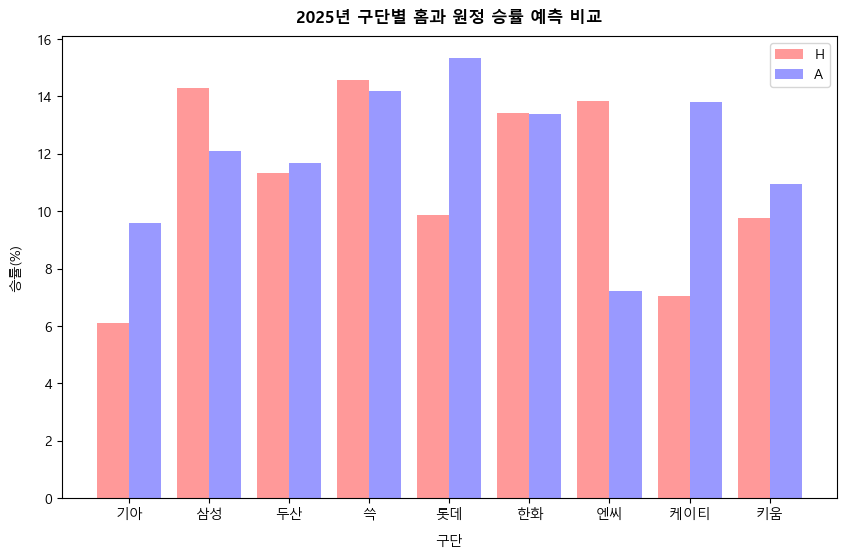

In [564]:
x = np.arange(len(df.index))

plt.figure(figsize=(10, 6))

w = 0.4
plt.bar(x-w/2, df['H'], width=w, label='H', color='r', alpha=0.4)
plt.bar(x+w/2, df['A'], width=w, label='A', color='b', alpha=0.4)

plt.xticks(ticks=x, labels=df.index)
plt.title("2025년 구단별 홈과 원정 승률 예측 비교", pad=10, weight='bold')
plt.xlabel("구단", labelpad=10)
plt.ylabel("승률(%)", labelpad=10)

plt.legend()
plt.show()